
<h2 align="center" style="margin-bottom: 0;">Proyecto Final de Estadística</h2>
<h2 align="center" style="margin-top: 0;">Análisis Predictivo de Rendimiento en Codeforces</h2>
<h3 align="center" style="margin-bottom: 0;">Integrantes</h3>
<p align="center">
- Ariel González Gómez C312 <br>
- Alex Samuel Bas Beovides C312 <br>
- Dario Rodríguez Llosa C312
</p>

# Introducción

El objetivo de este proyecto es construir un modelo de regresión lineal utilizando los datos de una muetra de usuarios activos de la plataforma de programación competitiva Codeforces, para predecir el **rating change** que experimentarán dentro de PREDICTION_DAYS días.

**Requisitos para incluir un usuario al conjunto de datos**:
- La cuenta de Codeforces fue registrada hace al menos PREDICTION_DAYS días, en los que el usuario haya participado en al menos REQUIRED_RATED_CONTESTS concursos reales.
- El usuario ha participado en al menos STABILIZATION_CONTESTS + REQUIRED_PREV_Rated_CONTESTS concursos antes de los últimos PREDICTION_DAYS días
- El usuario tiene al menos MIN_RATING_REQUIRED puntos de **rating**
- El **handle** del usuario no está en OUTLIERS

**Metaparámetros**:
- PREDICTION_DAYS = 60
- STABILIZATION_CONTESTS = 6
- MIN_RATING_REQUIRED = 1200
- REQUIRED_RATED_CONTESTS_DIV1 = 3
- REQUIRED_RATED_CONTESTS_NOT_DIV1 = 5
- REQUIRED_PREV_RATED_CONTESTS = 4
- DAYS_FOR_LAST_SOLVED = 30
- PROBLEM_SINGLE_PONDERATION_FUNCTION(x) = x ^ (3/2)
- PROBLEM_LIST_PONDERATION_FUNCTION([r_1, r_2, ..., r_n]) = sum (PROBLEM_SINGLE_PONDERATION_FUNCTION(r_i))
- INTERESTING_PROBLEM_SINGLE_PONDERATION_FUNCTION(x) = (x + 10) ^ (3/2)
- INTERESTING_PROBLEM_LIST_PONDERATION_FUNCTION([r_1, r_2, ..., r_n]) = sum (PROBLEM_SINGLE_PONDERATION_FUNCTION(r_i))
- INTERESTING_RANGE_L = -300
- INTERESTING_RANGE_R = +500
- USEFUL_RANGE_L = -800
* Si la calificación del usuario cuando se resolvió el problema es r, el problema es interesante si su calificación está en el rango [r + INTERESTING_RANGE_L, r + INTERESTING_RANGE_R]
- OUTLIERS = [rainboy, ruban, PAG, kaiboy]

**Características de entrada (variables independientes)** [información del usuario, anterior a los últimos PREDICTION_DAYS días]:
   - `rating`: rating actual.
   - `maxRating`: rating máximo alcanzado.
   - `daysSinceRegistered`: número de días transcurridos desde que se registró la cuenta en Codeforces.
   - `nRatedContestParticipations`: número de participaciones en concursos reales.
   - `nSolvedProblems`: cantidad de problemas distintos resueltos.
   - `nLastSolvedProblems`: cantidad de problemas distintos resueltos en los últimos DAYS_FOR_LAST_SOLVED días.
   - `solvedProblemsPonderation`: PROBLEM_LIST_PONDERATION_FUNCTION(L) (donde L es una lista de las dificultades de todos los problemas distintos resueltos).
   - `lastSolvedProblemsPonderation`: PROBLEM_LIST_PONDERATION_FUNCTION(L) (donde L es una lista de las dificultades de los problemas distintos resueltos en los últimos DAYS_FOR_LAST_SOLVED días).
   - `solvedInterestingProblemsPonderation`: INTERESTING_PROBLEM_LIST_PONDERATION_FUNCTION(L) (donde L es una lista de las dificultades de todos los problemas interesantes distintos resueltos).
   - `lastSolvedInterestingProblemsPonderation`: INTERESTING_PROBLEM_LIST_PONDERATION_FUNCTION(L) (donde L es una lista de las dificultades de los problemas interesantes distintos resueltos en los últimos DAYS_FOR_LAST_SOLVED días).
   - `contancy`: medida de la constancia en la actividad del usuario en la plataforma.
   - `solvedProblemsMean`: promedio de la dificultad de los problemas resueltos.
   - `lastSolvedProblemsMean`: promedio de la dificultad de los problemas resueltos en los últimos DAYS_FOR_LAST_SOLVED días.
   - De los últimos REQUIRED_PREV_RATED_CONTESTS concursos reales en los que participó el usuario:
     - `ratingChangeNthLatestContest`: cambio de rating que tuvo el usuario en el n-ésimo último contest real (n=1: último, n=2: penúltimo, n=3: antepenúltimo...)

**Variable de salida**: `futureRating`(implica predecir el rating que tendrá un usuario dentro de PREDICTION_DAYS días [en el caso de los usuarios del dataset esta es la calificación extraída], suponiendo que en ese tiempo participará en al menos REQUIRED_Rated_CONTESTS concursos reales)
  

# Preparación del Entorno

Antes de comenzar con el análisis, necesitamos asegurarnos de que todas las bibliotecas necesarias estén instaladas. Esto incluye `os` para el trabajo con archivos, `requests` para el trabajo con la API, `json` para el trabajo con formato JSON, `time` para variables temporales y obtención de tiempo actual, `pandas` para la manipulación de datos, `math` y `numpy` para cálculos numéricos, `matplotlib` y `seaborn` para la visualización de datos, y `sklearn` para el aprendizaje automático.


### Instalación y carga de bibliotecas

In [24]:
required_libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'statsmodels', 'scipy', 'os', 'json', 'time', 'math', 'requests']

def install_missing_libraries(libraries):
    import subprocess
    import sys
    for library in libraries:
        try:
            __import__(library)
        except ImportError:
            print(f"La biblioteca {library} no está instalada. Instalando ahora...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])

install_missing_libraries(required_libraries)

La biblioteca scikit-learn no está instalada. Instalando ahora...


In [25]:
from collections import Counter
from statistics import mean
import os
import requests
import json
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Configuración de entorno (Google Drive)

In [2]:
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/Codeforces Statistics Project/'

Mounted at /content/drive


# Funciones útiles

In [5]:
# Function to format a number with leading zeros
def zero_fill(n, t):
  n = str(n)
  return '0'*(t-len(n))+n

# Function to convert bytes to megabytes
def bytes_to_megabytes(data):
  print(' (~ ', end='')
  print("%.2f" % round(data/1e6, 2), end='')
  print(' MB)')

# Function to convert bytes to gigabytes
def bytes_to_gigabytes(data):
  print(' (~ ', end='')
  print("%.2f" % round(data/1e9, 2), end='')
  print(' GB)')

# Function to convert days to seconds
def days_to_seconds(days):
  return days * 86400  # 24h * 60m * 60s

# Function to convert seconds to days
def seconds_to_days(seconds):
  return seconds // 86400  # 24h * 60m * 60s

# Function to get the current time
def get_current_time():
  return int(time.time())

# Dictionary of ordinal suffixes
ORDINAL_SUFFIXES = {1: 'st', 2: 'nd', 3: 'rd'}

# Function to get the ordinal representation of a number
def get_ordinal(i):
    if 10 <= i % 100 <= 20:
        return str(i) + 'th'
    else:
        return str(i) + ORDINAL_SUFFIXES.get(i % 10, 'th')

<hr>

# Obtención del conjunto de datos

Los datos de este proyecto deben ser obtenidos a través de la API de Codeforces, y luego procesados para extraer las features relevantes.

## Trabajo con la API

Variables Globales

In [6]:
users_data = 0
users_data_df = 0
extended_users_data_df = 0
current_batch = 701 # -------------------------- CHANGE BEFORE RUNNING --------------------------
batch_size = 50
processed_users = {''}

Métodos de la API de Codeforces

In [ ]:
def fetch_users_data():
    url = 'https://codeforces.com/api/user.ratedList?activeOnly=true&includeRetired=false'
    response = requests.get(url)
    data = response.json()
    return data['result']

def fetch_users_rated_contests(handle):
    url = 'https://codeforces.com/api/user.rating?handle='+handle
    response = requests.get(url)
    data = response.json()
    return data['result']

def fetch_users_submissions(handle):
    url = 'https://codeforces.com/api/user.status?handle='+handle
    response = requests.get(url)
    data = response.json()
    return data['result']

Inicialización de los datos crudos de los usuarios

In [26]:
def remove_processed_users():
  global users_data_df
  global processed_users
  for i in range(1, current_batch):
    if i % 10 == 0:
      print(i)
    batch = pd.read_csv(root_path+'extended_users_data_batch_'+zero_fill(i,4)+'.csv')
    batch_df = pd.DataFrame(batch)
    for id in batch_df.index:
      handle = batch_df.loc[id, "handle"]
      processed_users.add(handle)

  for id in users_data_df.index:
    handle = users_data_df.loc[id, "handle"]
    if handle in processed_users:
      users_data_df.drop(id, inplace = True)


def init_users_data():
  global users_data
  global users_data_df

  # users_data = fetch_users_data()
  users_data = pd.read_csv(root_path+'users_data.csv')
  users_data_df = pd.DataFrame(users_data)
  users_data_df = users_data_df.sample(frac=1)
  # remove_processed_users()


def init_extended_users_data():
  global users_data_df
  global extended_users_data_df

  columns = users_data_df.columns.tolist()
  columns.append('submissions')
  columns.append('ratedContests')

  extended_users_data_df = pd.DataFrame(columns=columns)


def init_raw_dataframes():
  init_users_data()
  init_extended_users_data()

Obtención y guardado de los datos

In [27]:
def make_batch_backup():
  global current_batch
  global extended_users_data_df
  extended_users_data_df.to_csv(root_path+'extended_users_data_batch_'+zero_fill(current_batch,4)+'.csv', index=False)
  users_data_df.to_csv(root_path+'users_data'+'.csv', index=False)
  init_extended_users_data()

  print('----------BACKUP---------- BATCH:', current_batch)
  current_batch += 1

def get_raw_data():
  i = 0 # number of processed rows in this run

  # Iterate over remaining users
  for id in users_data_df.index:
    i += 1
    handle = users_data_df.loc[id, "handle"]

    contests = fetch_users_rated_contests(handle)
    submissions = fetch_users_submissions(handle)

    features = []
    for feature in users_data_df.columns:
      features.append(users_data_df.loc[id, feature])

    features.append(submissions)
    features.append(contests)

    # Add this new row to the dataframe
    extended_users_data_df.loc[len(extended_users_data_df.index)] = features

    # Control output
    print(i, extended_users_data_df.shape[0])

    # Save batch when too big
    if extended_users_data_df.shape[0] % batch_size == 0:
      make_batch_backup()

    users_data_df.drop(id, inplace = True)

In [28]:
init_raw_dataframes() # Init

NameError: name 'root_path' is not defined

In [ ]:
get_raw_data() # Keep fetching raw data

<hr>

## Revisión y análisis de los archivos de datos crudos

In [29]:
# Funcion to analize the memory usage of the batches of saved data
def batches_analisis():
  n_saved_batches = current_batch - 1
  n_processed_users = n_saved_batches * batch_size
  n_remaining_users = users_data_df.shape[0]
  n_total_users = n_processed_users + n_remaining_users

  print('Cantidad de lotes guardados:', n_saved_batches)
  print('Tamaño de lote:', batch_size)
  print('Cantidad de usuarios procesados:', n_processed_users)
  print('Cantidad de usuarios restantes:', n_remaining_users)
  print('Cantidad total de usuarios:', n_total_users)

  total_memory_used = 0

  # print('Memory used per batch:')
  for i in range(1, n_saved_batches + 1):
    memory = os.stat(root_path+'extended_users_data_batch_'+zero_fill(i,4)+'.csv').st_size
    total_memory_used += int(memory)
    # print('- Batch #'+str(i)+':', memory,'B', end='')
    # bytes_to_megabytes(memory)

  average_memory_used_per_user = total_memory_used / n_processed_users
  expected_remaining_memory_to_use = average_memory_used_per_user * n_remaining_users
  expected_total_memory_to_use = total_memory_used + expected_remaining_memory_to_use

  print('Cantidad total de memoria utilizada:', total_memory_used, 'B', end='')
  bytes_to_gigabytes(total_memory_used)
  print('Promedio de la cantidad de memoria utilizada por usuario:', average_memory_used_per_user,'B', end='')
  bytes_to_megabytes(average_memory_used_per_user)
  print('Cantidad restante esperada de memoria a utilizar: ~', expected_remaining_memory_to_use,'B', end='')
  bytes_to_gigabytes(expected_remaining_memory_to_use)
  print('Cantidad total esperada de memoria a utilizar: ~', expected_total_memory_to_use,'B', end='')
  bytes_to_gigabytes(expected_total_memory_to_use)

In [ ]:
batches_analisis()

Cantidad de lotes guardados: 700
Tamaño de lote: 50
Cantidad de usuarios procesados: 35000
Cantidad de usuarios restantes: 25145
Cantidad total de usuarios: 60145
Cantidad total de memoria utilizada: 9129726433 B (~ 9.13 GB)
Promedio de la cantidad de memoria utilizada por usuario: 260849.32665714287 B (~ 0.26 MB)
Cantidad restante esperada de memoria a utilizar: ~ 6559056318.793858 B (~ 6.56 GB)
Cantidad total esperada de memoria a utilizar: ~ 15688782751.793858 B (~ 15.69 GB)


<hr>

## Extracción de las variables de entrada


Los datos crudos obtenidos a través de la API son procesados para extraer las variables de entrada relevantes para el problema.

In [30]:
metaparameters={
  'PREDICTION_DAYS': 60,
  'STABILIZATION_CONTESTS': 6,
  'MIN_RATING_REQUIRED': 1200,
  'REQUIRED_RATED_CONTESTS_DIV1': 3,
  'REQUIRED_RATED_CONTESTS_NOT_DIV1': 5,
  'REQUIRED_PREV_RATED_CONTESTS': 4,
  'STABILIZATION_RATED_CONTESTS': 6,
  'DAYS_FOR_LAST_SOLVED': 200,
  'PROBLEM_SINGLE_PONDERATION_FUNCTION': lambda x : x**(3/2),
  'PROBLEM_LIST_PONDERATION_FUNCTION': lambda l : sum(map(metaparameters['PROBLEM_SINGLE_PONDERATION_FUNCTION'], l)),
  'INTERESTING_PROBLEM_SINGLE_PONDERATION_FUNCTION': lambda x : (x+10)**(3/2),
  'INTERESTING_PROBLEM_LIST_PONDERATION_FUNCTION': lambda l : sum(map(metaparameters['INTERESTING_PROBLEM_SINGLE_PONDERATION_FUNCTION'], l)),
  'INTERESTING_RANGE_L': -300,
  'INTERESTING_RANGE_R': 500,
  'USEFUL_RANGE_L': -800,
  'OUTLIERS': ['rainboy', 'ruban', 'PAG', 'kaiboy']
}

In [31]:
# Returns a pandas Dataframe with only the relevant columns of the processed users
def get_empty_processed_users_data_df():
  df = pd.DataFrame()

  columns = ["handle", "dataExtractionTime", "rating", "maxRating", "nRatedContestParticipations", "daysSinceRegistered", "nSolvedProblems", "nLastSolvedProblems", "solvedProblemsPonderation",
            "lastSolvedProblemsPonderation", "solvedInterestingProblemsPonderation", "lastSolvedInterestingProblemsPonderation", "constancy", "solvedProblemsMean", "lastSolvedProblemsMean"]

  for i in range(0,metaparameters['REQUIRED_PREV_RATED_CONTESTS']):
    columns.append("performance" + get_ordinal(i + 1) + 'LatestContest')

  columns.append("ratingChange")
  columns.append("futureRating")

  for column in columns:
    df.insert(df.shape[1], column, [], True)

  return df

Inicialización

In [32]:
processed_users_data_df = get_empty_processed_users_data_df()

n_processed_batches = 0
n_valid_users = 0
n_discarded_users = 0

Procesamiento

In [33]:
# Extract features of users that fulfill the requirements
def get_relevant_data():
  global n_processed_batches
  global n_valid_users
  global n_discarded_users
  global processed_users_data_df

  # Iterate over remaining batches
  for i in range(n_processed_batches + 1, current_batch):
    # Load the batch
    batch = pd.read_csv(root_path+'extended_users_data_batch_'+zero_fill(i,4)+'.csv')
    batch_df = pd.DataFrame(batch)

    # Control output
    # print('Batch #'+str(i)+':')

    # Batch variables
    j = 0 # index of current user in the batch
    df = get_empty_processed_users_data_df() # dataframe for processed users of the batch
    n_batch_valid_users = 0
    n_batch_discarded_users = 0

    # Iterate over the users of the current batch
    for id in batch_df.index:
      j += 1
      handle = batch_df.loc[id, "handle"]

      # Discard if the user is an outlier
      if handle in metaparameters['OUTLIERS']:
        # print('-', j, "DISCARDED O")
        n_batch_discarded_users += 1
        continue

      # Rated contests data
      rated_contests_str = batch_df.loc[id, 'ratedContests']
      rated_contests = list(eval(rated_contests_str))

      futureRating = rated_contests[-1]['newRating']

      '''
      # Discard low rated users
      if futureRating < metaparameters['MIN_RATING_REQUIRED']:
        # print('-', j, "DISCARDED R")
        n_batch_discarded_users += 1
        continue
      '''

      if i <= 200:
        dataExtractionTime = 1711747800 # upperbound for the users until batch #200
      elif i <= 700:
        # dataExtractionTime = 1712457820
        dataExtractionTime = 1712502148

      rating = 0
      maxRating = 0
      daysSinceRegistered = seconds_to_days(dataExtractionTime - batch_df.loc[id, "registrationTimeSeconds"])
      nRatedContestParticipations = len(rated_contests)

      prediction_time = dataExtractionTime - days_to_seconds(metaparameters['PREDICTION_DAYS'])
      last_solved_time = prediction_time - days_to_seconds(metaparameters['DAYS_FOR_LAST_SOLVED'])
      n_future_rated_contests = 0

      # Iterate over the reversed list of rated contests to find the last one up to the prediction time
      for contest in reversed(rated_contests):
        # If last one found
        if contest['ratingUpdateTimeSeconds'] < prediction_time:
          rating = contest['newRating']
          break
        n_future_rated_contests += 1

      # Discard low rated users
      if rating < metaparameters['MIN_RATING_REQUIRED']:
        # print('-', j, "DISCARDED R")
        n_batch_discarded_users += 1
        continue

      # Iterate over the list of rated contests to find the user's maximum rating
      for contest in rated_contests:
        if contest['ratingUpdateTimeSeconds'] >= prediction_time:
          break
        maxRating = max(maxRating, contest['newRating'])

      # Find corresponding division
      if rating >= 2100:
        REQUIRED_RATED_CONTESTS = metaparameters['REQUIRED_RATED_CONTESTS_DIV1']
      else:
        REQUIRED_RATED_CONTESTS = metaparameters['REQUIRED_RATED_CONTESTS_NOT_DIV1']

      TOTAL_REQUIRED_PREV_RATED_CONTESTS = metaparameters['STABILIZATION_RATED_CONTESTS'] + metaparameters['REQUIRED_PREV_RATED_CONTESTS']
      nRatedContestParticipations -= n_future_rated_contests

      # Discard the user if low amount of contests between the prediction time and the data extraction time, or low total amount of rated contests
      if n_future_rated_contests < REQUIRED_RATED_CONTESTS or nRatedContestParticipations < TOTAL_REQUIRED_PREV_RATED_CONTESTS:
        # print('-', j, "DISCARDED C")
        n_batch_discarded_users += 1
        continue

      # Submissions data
      submissions_str = batch_df.loc[id, 'submissions']
      submissions = list(eval(submissions_str))

      # Problems-related features
      nSolvedProblems = 0
      nLastSolvedProblems = 0
      solvedProblemsList = []
      lastSolvedProblemsList = []
      solvedInterestingProblemsList = []
      lastSolvedInterestingProblemsList = []
      constancy = 0
      last_day = -10
      streak = 0
      cur_n_solved = 0
      set_of_solved = {""}

      # Iterate over all current user's submissions
      for submission in reversed(submissions):
        # Discard non-AC
        if 'verdict' in submission:
          if submission['verdict'] != 'OK':
            continue
        else:
          continue

        # Get contest ID of current problem
        contest_id = 0
        if 'contestId' in submission:
          contest_id = submission['contestId']
        elif 'contestId' in submission['problem']:
          contest_id = submission['problem']['contestId']

        # Get current problem's ID
        problem_id = str(contest_id) +'_'+ submission['problem']['index']

        # Discard if seen before, otherwise include in the set of solveds
        if problem_id in set_of_solved:
          continue
        set_of_solved.add(problem_id)

        # Update contancy value
        cur_day = seconds_to_days(dataExtractionTime - submission['creationTimeSeconds']) + 1
        if cur_day == last_day:
          cur_n_solved += 1
        elif cur_day == last_day - 1:
          cur_n_solved = 1
          streak += 1
        else:
          cur_n_solved = 1
          streak = 1
        last_day = cur_day
        if cur_day <= 60:
          constancy += (streak**(4/3)) / (cur_n_solved * cur_day**(3/2))

        # If the problem has an assigned rating/difficulty
        if 'rating' in submission['problem']:
          # Finish if from now on the problems were solved after the prediction time
          if submission['creationTimeSeconds'] >= prediction_time:
            break

          problem_rating = submission['problem']['rating']

          # If the problem is in the useful range
          if problem_rating >= rating + metaparameters['USEFUL_RANGE_L']:
            solvedProblemsList.append(problem_rating - (rating + metaparameters['USEFUL_RANGE_L']))
            nSolvedProblems += 1

          # If the problem is in the interesting range
          if rating + metaparameters['INTERESTING_RANGE_L'] <= problem_rating and problem_rating <= rating + metaparameters['INTERESTING_RANGE_R']:
            solvedInterestingProblemsList.append(problem_rating - (rating + metaparameters['INTERESTING_RANGE_L']))


          # If the problem is of the last ones solved
          if submission['creationTimeSeconds'] >= last_solved_time:
            if rating + metaparameters['USEFUL_RANGE_L'] <= problem_rating:
              lastSolvedProblemsList.append(problem_rating - (rating + metaparameters['USEFUL_RANGE_L']))
              nLastSolvedProblems += 1
            if rating + metaparameters['INTERESTING_RANGE_L'] <= problem_rating and problem_rating <= rating+metaparameters['INTERESTING_RANGE_R']:
              lastSolvedInterestingProblemsList.append(problem_rating - (rating + metaparameters['INTERESTING_RANGE_L']))

      # Solved problems ponderation features
      solvedProblemsPonderation = metaparameters['PROBLEM_LIST_PONDERATION_FUNCTION'](solvedProblemsList)
      lastSolvedProblemsPonderation = metaparameters['PROBLEM_LIST_PONDERATION_FUNCTION'](lastSolvedProblemsList)
      solvedInterestingProblemsPonderation = metaparameters['INTERESTING_PROBLEM_LIST_PONDERATION_FUNCTION'](solvedInterestingProblemsList)
      lastSolvedInterestingProblemsPonderation = metaparameters['INTERESTING_PROBLEM_LIST_PONDERATION_FUNCTION'](lastSolvedInterestingProblemsList)

      # Features of mean rating of solved problems
      if len(solvedProblemsList)>0:
        solvedProblemsMean = mean(solvedProblemsList)
      else:
        solvedProblemsMean = 0

      if len(lastSolvedProblemsList)>0:
        lastSolvedProblemsMean = mean(lastSolvedProblemsList)
      else:
        lastSolvedProblemsMean = 0

      # Group all the extracted features
      features = [handle, dataExtractionTime, rating, maxRating, nRatedContestParticipations, daysSinceRegistered, nSolvedProblems, nLastSolvedProblems,
                  solvedProblemsPonderation, lastSolvedProblemsPonderation, solvedInterestingProblemsPonderation, lastSolvedInterestingProblemsPonderation, constancy, solvedProblemsMean, lastSolvedProblemsMean]

      # Rating changes of latest rated contests of the user
      for k in range(0,metaparameters['REQUIRED_PREV_RATED_CONTESTS']):
        contest = rated_contests[nRatedContestParticipations - 1 - k]
        oldRating = contest['oldRating']
        features.append(oldRating + (contest['newRating'] - oldRating) * 4)
        # features.append(contest['newRating'] - contest['oldRating'])

      # Features to predict
      ratingChange = futureRating - rating
      features.append(ratingChange)
      features.append(futureRating)

      # Add new valid user
      df.loc[len(df.index)] = features
      n_batch_valid_users += 1

      # Control output
      # print('-', j, handle, "ACCEPTED")

    # Add the batch
    processed_users_data_df = pd.concat([processed_users_data_df,df])
    n_valid_users += n_batch_valid_users
    n_discarded_users += n_batch_discarded_users

    # Control output
    print('Batch #'+str(i)+' DONE. Valid:', n_batch_valid_users, 'Discarded:', n_batch_discarded_users)
    n_processed_batches += 1

In [ ]:
get_relevant_data() # Keep processing the data

Batch #262 DONE. Valid: 6 Discarded: 44
Batch #263 DONE. Valid: 3 Discarded: 47
Batch #264 DONE. Valid: 3 Discarded: 47
Batch #265 DONE. Valid: 8 Discarded: 42
Batch #266 DONE. Valid: 10 Discarded: 40
Batch #267 DONE. Valid: 11 Discarded: 39
Batch #268 DONE. Valid: 8 Discarded: 42
Batch #269 DONE. Valid: 5 Discarded: 45
Batch #270 DONE. Valid: 5 Discarded: 45
Batch #271 DONE. Valid: 4 Discarded: 46
Batch #272 DONE. Valid: 8 Discarded: 42
Batch #273 DONE. Valid: 5 Discarded: 45
Batch #274 DONE. Valid: 7 Discarded: 43
Batch #275 DONE. Valid: 2 Discarded: 48
Batch #276 DONE. Valid: 6 Discarded: 44
Batch #277 DONE. Valid: 4 Discarded: 46
Batch #278 DONE. Valid: 9 Discarded: 41
Batch #279 DONE. Valid: 2 Discarded: 48
Batch #280 DONE. Valid: 5 Discarded: 45
Batch #281 DONE. Valid: 5 Discarded: 45
Batch #282 DONE. Valid: 9 Discarded: 41
Batch #283 DONE. Valid: 9 Discarded: 41
Batch #284 DONE. Valid: 9 Discarded: 41
Batch #285 DONE. Valid: 3 Discarded: 47
Batch #286 DONE. Valid: 6 Discarded: 4

Guardado de los datos procesados

In [ ]:
processed_users_data_df.to_csv(root_path+'processed_users_data.csv', index=False)

<hr>

# Análisis Exploratorio de Datos (EDA)
El Análisis Exploratorio de Datos (EDA) es un paso crucial en cualquier proyecto de análisis de datos. Nos permite comprender la estructura y las relaciones dentro de nuestro conjunto de datos antes de realizar cualquier modelado o predicción. En este proyecto, nuestro objetivo es construir un modelo de regresión lineal para predecir el cambio de rating que los usuarios activos de la plataforma de programación competitiva Codeforces experimentarán en un período de tiempo definido por PREDICTION_DAYS.

En nuestro EDA, comenzaremos con una visión general de los datos disponibles para nosotros. Esto incluirá una descripción de las variables en nuestro conjunto de datos, así como una visión inicial de las distribuciones y estadísticas descriptivas de estas variables.

A continuación, nos centraremos en la limpieza y preprocesamiento de los datos. Este paso es esencial para garantizar la calidad y precisión de nuestros análisis posteriores. Trataremos los valores faltantes y duplicados, y realizaremos cualquier transformación necesaria para preparar nuestros datos para el modelado.

Una vez que nuestros datos estén limpios y preparados, procederemos a un análisis más detallado de las variables. Esto incluirá el análisis univariable y bivariable, donde examinaremos las distribuciones de las variables individuales y las relaciones entre las variables, respectivamente.

Finalmente, abordaremos el tema de los valores atípicos. Los valores atípicos pueden tener un impacto significativo en un modelo de regresión lineal, por lo que es importante identificar y tratar adecuadamente estos valores.

Al final de nuestro EDA, tendremos una comprensión sólida de nuestros datos y estaremos listos para proceder con la construcción de nuestro modelo de regresión lineal.


<hr>

## Carga de Datos
Cargaremos el conjunto de datos y mostraremos las primeras filas para dar una idea de cómo se ven los datos.

In [36]:
processed_users_data = pd.read_csv('processed_users_data.csv')
processed_users_data_df = pd.DataFrame(processed_users_data)
processed_users_data_df = processed_users_data_df.drop(['handle', 'dataExtractionTime'], axis=1) # remove the unnecesary columns
processed_users_data_df = processed_users_data_df.reset_index(drop=True) # deindex the dataframe

In [37]:
processed_users_data_df.head()

,rating,maxRating,nRatedContestParticipations,daysSinceRegistered,nSolvedProblems,nLastSolvedProblems,solvedProblemsPonderation,lastSolvedProblemsPonderation,solvedInterestingProblemsPonderation,lastSolvedInterestingProblemsPonderation,constancy,solvedProblemsMean,lastSolvedProblemsMean,performance1stLatestContest,performance2ndLatestContest,performance3rdLatestContest,performance4thLatestContest,ratingChange,futureRating
0,1453.0,1547.0,23.0,3351.0,233.0,63.0,5.068383e+06,1.759466e+06,1.094232e+06,3.400229e+05,0.002264,713.952790,840.650794,1522.0,1421.0,1535.0,1450.0,164.0,1617.0
1,1631.0,1675.0,41.0,416.0,149.0,126.0,1.738129e+06,1.605290e+06,2.850015e+05,2.795096e+05,0.009310,465.644295,496.777778,1580.0,1786.0,1842.0,1195.0,-104.0,1527.0
2,1754.0,1815.0,103.0,665.0,1078.0,366.0,1.618091e+07,9.185458e+06,3.456803e+06,2.762219e+06,0.005422,558.430427,811.027322,1736.0,1760.0,2060.0,1978.0,-10.0,1744.0
3,1506.0,1506.0,38.0,514.0,388.0,332.0,4.787140e+06,4.250879e+06,9.932145e+05,9.370272e+05,0.002152,465.907216,483.759036,1605.0,1533.0,1297.0,1652.0,24.0,1530.0
4,1441.0,1567.0,10.0,578.0,86.0,66.0,3.048441e+06,2.843251e+06,2.688994e+05,2.243843e+05,0.018396,981.093023,1151.424242,1228.0,1347.0,1909.0,1237.0,97.0,1538.0


<hr>

## Resumen de los Datos
Usaremos métodos como info() para obtener informacion general del dataset, describe() para obtener un resumen estadístico de los datos, nunique() para obtener la cantidad de valores únicos por columna.

Información general sobre el Dataframe

In [38]:
processed_users_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4031 entries, 0 to 4030
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rating                                    4031 non-null   float64
 1   maxRating                                 4031 non-null   float64
 2   nRatedContestParticipations               4031 non-null   float64
 3   daysSinceRegistered                       4031 non-null   float64
 4   nSolvedProblems                           4031 non-null   float64
 5   nLastSolvedProblems                       4031 non-null   float64
 6   solvedProblemsPonderation                 4031 non-null   float64
 7   lastSolvedProblemsPonderation             4031 non-null   float64
 8   solvedInterestingProblemsPonderation      4031 non-null   float64
 9   lastSolvedInterestingProblemsPonderation  4031 non-null   float64
 10  constancy                           

Descripción general de cada columna (conteo, la media, la desviación estándar, los valores mínimos y máximos, y los cuartiles)

In [39]:
processed_users_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,4031.0,1.522851e+03,3.005334e+02,1200.000000,1.305000e+03,1.434000e+03,1.648000e+03,3.572000e+03
maxRating,4031.0,1.594673e+03,3.238613e+02,1200.000000,1.367000e+03,1.507000e+03,1.726000e+03,3.979000e+03
nRatedContestParticipations,4031.0,5.608410e+01,5.228695e+01,10.000000,2.300000e+01,3.900000e+01,7.000000e+01,7.060000e+02
daysSinceRegistered,4031.0,8.661486e+02,6.733646e+02,104.000000,4.520000e+02,6.730000e+02,1.068000e+03,5.173000e+03
nSolvedProblems,4031.0,3.972878e+02,3.663579e+02,22.000000,1.410000e+02,2.820000e+02,5.420000e+02,3.709000e+03
nLastSolvedProblems,4031.0,1.451541e+02,1.206422e+02,0.000000,5.700000e+01,1.140000e+02,1.990000e+02,1.155000e+03
solvedProblemsPonderation,4031.0,5.866608e+06,6.130960e+06,182441.873387,1.839190e+06,3.926602e+06,7.853017e+06,6.418888e+07
lastSolvedProblemsPonderation,4031.0,2.472203e+06,2.336906e+06,0.000000,7.746451e+05,1.732244e+06,3.494305e+06,1.820977e+07
solvedInterestingProblemsPonderation,4031.0,1.166446e+06,1.407280e+06,17204.166996,2.954710e+05,7.014168e+05,1.520975e+06,1.398145e+07
lastSolvedInterestingProblemsPonderation,4031.0,5.359624e+05,5.897226e+05,0.000000,1.283315e+05,3.376097e+05,7.332918e+05,4.678577e+06


Cantidad de valores únicos para cada columna

In [41]:
processed_users_data_df.nunique()

rating                                       984
maxRating                                   1075
nRatedContestParticipations                  244
daysSinceRegistered                         1569
nSolvedProblems                             1084
nLastSolvedProblems                          508
solvedProblemsPonderation                   4030
lastSolvedProblemsPonderation               4003
solvedInterestingProblemsPonderation        4030
lastSolvedInterestingProblemsPonderation    3995
constancy                                    189
solvedProblemsMean                          4001
lastSolvedProblemsMean                      3917
performance1stLatestContest                 1296
performance2ndLatestContest                 1323
performance3rdLatestContest                 1347
performance4thLatestContest                 1311
ratingChange                                 594
futureRating                                1124
dtype: int64

<hr>

## Limpieza de datos
La limpieza de datos, también conocida como data cleansing o data cleaning, es el proceso de identificar y corregir errores, inconsistencias y datos incompletos o duplicados en un conjunto de datos. Es una parte fundamental del análisis de datos y la preparación de datos para su posterior uso en aplicaciones y análisis.

La forma en que se obtiene nuestro conjunto de datos asegura su completitud y consistencia, lo que se pudo comprobar con la función info(), sin embargo se incluye la siguiente limpieza explícita para descartar cualquier casualidad:

In [42]:
processed_users_data_df = processed_users_data_df.dropna()

<hr>

## Análisis de Outliers
Utilizaremos gráficos de caja y métodos estadísticos para identificar los valores atípicos. En función de la naturaleza de los valores atípicos, decidiremos si queremos mantenerlos, eliminarlos o transformarlos.


In [43]:
def graph_violin_box_plots(df):
  all_features = df.columns
  fig, axs = plt.subplots(nrows = len(all_features), ncols= 2, figsize=(10,80))
  for i,col in enumerate(all_features[0:]):
      sns.histplot(df[col], ax=axs[i, 0], kde=True, color='blue')
      axs[i, 1].violinplot(df[col])
      axs[i, 1].boxplot(df[col], showmeans = True, meanline = True)
  plt.show()

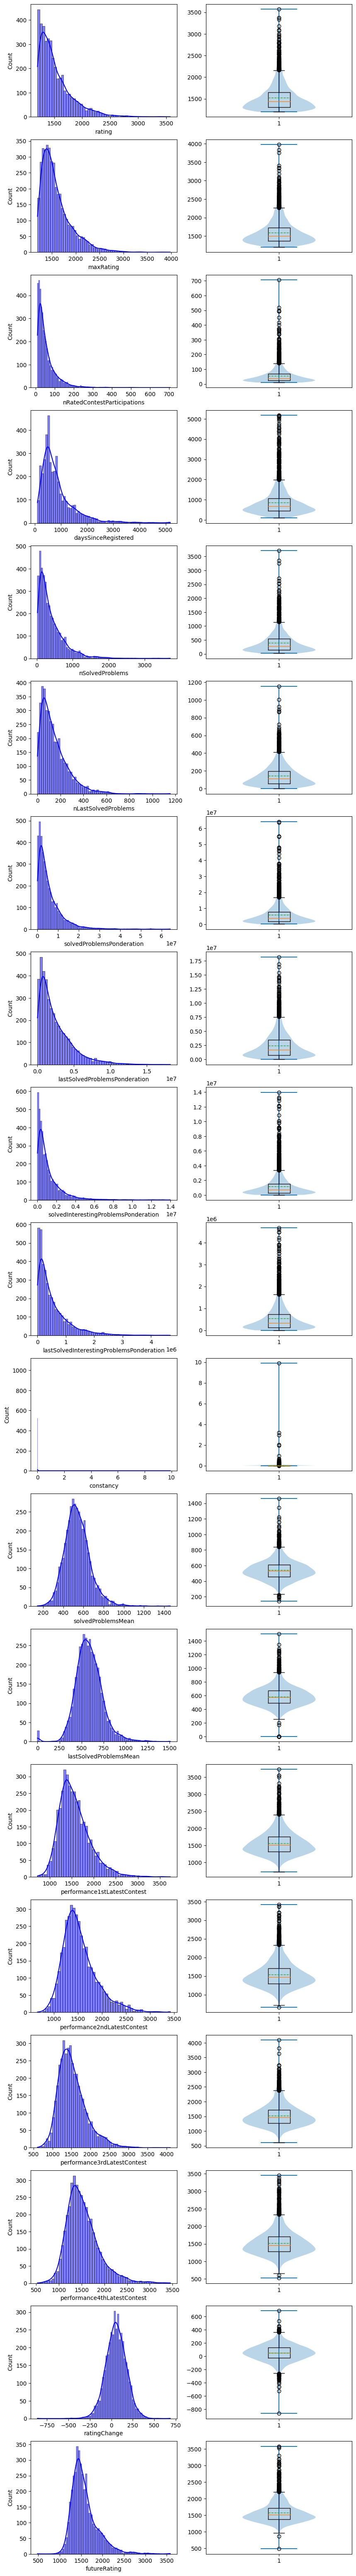

In [17]:
graph_violin_box_plots(processed_users_data_df)

In [44]:
def erase_outliers_by_feature(df, feature):
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  filter = (df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 *IQR)
  filtered_df= df.loc[filter]
  return filtered_df

In [45]:
def erase_outliers(df):
  all_features = ['ratingChange', 'nLastSolvedProblems', 'solvedProblemsPonderation', 'constancy']

  for feature in all_features:
    df = erase_outliers_by_feature(df, feature)

  return df

Descartaremos los datos de los usuarios tales que al menos una de las siguientes características representa un outlier en el dataset:
- `ratingChange`: pues un ratingChange de valor absoluto muy grande puede indicar la presencia de un usuario usando una cuenta alternativa, haciendo trampas, o simplemente "trolleando".
- `nLastSolvedProblems`: pues hay muchos usuarios (normalmente novatos) que mandan soluciones de muchos problemas sin realmente resolverlos por si mismo, ya sea por autoengaño, trampa, o aburrimiento.
- `solvedProblemsPonderation`: pues la función de ponderación definida da valores inusualmente grandes para usuarios de perfil sospechoso, y que pueden afectar el resultado del OLS.
- `constancy`: pues la función de ponderación de la constancia de un usuario genera valores muy grandes para usuarios que llevan una racha extremadamente larga y que por lo general es obtenida a través de un envío fallido diario de una solución a un problema, o una solución repetida, solo para mantener la racha. Además estos valores pueden afectar seriamente el resultado del OLS.

In [46]:
processed_users_data_df = erase_outliers(processed_users_data_df)

<hr>

## Análisis Univariable
Analizaremos cada variable por separado, usando histogramas y gráficos de densidad

Gráfico de barras de distribución por rating

In [47]:
import matplotlib.colors as mcolors

color_newbie = '#808080'
color_pupil = '#008000'
color_specialist = '#03a89e'
color_expert = '#0000ff'
color_candidate_master = '#a0a'
color_master = '#ff8c00'
color_international_master = '#ff8c00'
color_grandmaster = '#ff0000'
color_international_grandmaster = '#ff0000'
color_legendary_grandmaster = '#ff0000'

rating_colors_hex = {
    0: color_newbie,
    100: color_newbie,
    200: color_newbie,
    300: color_newbie,
    400: color_newbie,
    500: color_newbie,
    600: color_newbie,
    700: color_newbie,
    800: color_newbie,
    900: color_newbie,
    1000: color_newbie,
    1100: color_newbie,
    1200: color_pupil,
    1300: color_pupil,
    1400: color_specialist,
    1500: color_specialist,
    1600: color_expert,
    1700: color_expert,
    1800: color_expert,
    1900: color_candidate_master,
    2000: color_candidate_master,
    2100: color_master,
    2200: color_master,
    2300: color_international_master,
    2400: color_grandmaster,
    2500: color_grandmaster,
    2600: color_international_grandmaster,
    2700: color_international_grandmaster,
    2800: color_international_grandmaster,
    2900: color_legendary_grandmaster,
    3000: color_legendary_grandmaster,
    3100: color_legendary_grandmaster,
    3200: color_legendary_grandmaster,
    3300: color_legendary_grandmaster,
    3400: color_legendary_grandmaster,
    3500: color_legendary_grandmaster,
    3600: color_legendary_grandmaster,
    3700: color_legendary_grandmaster,
    3800: color_legendary_grandmaster,
    3900: color_legendary_grandmaster,
}

def graph_ratings(df):
    users_count = 0
    ratings = [i for i in range(0, 4001)]  # Create a list of all possible ratings from 0 to 4000
    rating_counts = Counter(ratings)        # Initialize counts for all ratings to one
    for id in df.index:
        rating = df.loc[id, "rating"]
        rating_counts[rating] += 1

    # Define rating ranges
    ranges = [(i, i + 99) for i in range(metaparameters["MIN_RATING_REQUIRED"], 4000, 100)]
    # Define handle colors

    # Create bar graph
    plt.figure(figsize=(10, 4))  # Width: 10 inches, Height: 6 inches
    for i, (start, end) in enumerate(ranges):
        total_count = sum(rating_counts[r] for r in range(start, end+1)) - (end - start + 1)
        color = mcolors.hex2color(rating_colors_hex.get(start, '#808080'))
        bar = plt.bar(i, total_count, color=color)

        # Add count number over each bar
        plt.text(bar[0].get_x() + bar[0].get_width() / 2.0, bar[0].get_height(), " " + str(total_count),
                ha='center', va='bottom', rotation=90, fontsize=6)

    plt.xticks(range(len(ranges)), ['{}-{}'.format(start, end) for start, end in ranges], rotation=90, fontsize=7)
    plt.xlabel('Rating')
    plt.ylabel('Total Count')
    plt.title('Codeforces Active Users Rating Distribution')
    plt.show()

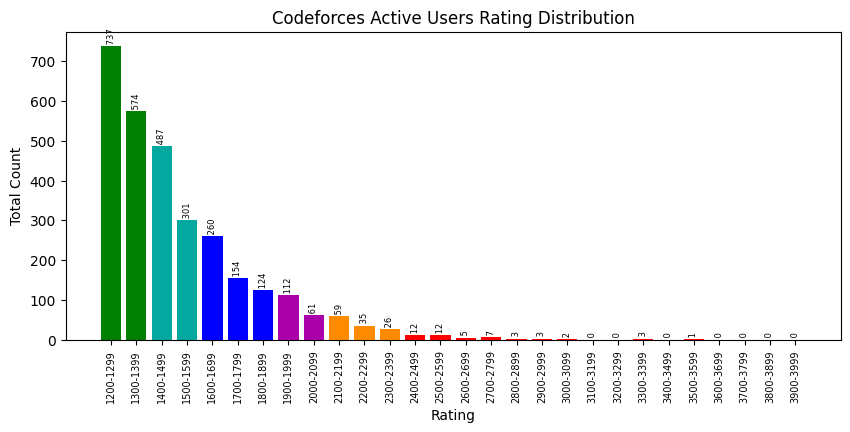

In [48]:
graph_ratings(processed_users_data_df)

Histogramas

In [49]:
def graph_histplots(df):
  all_features = ['ratingChange','futureRating','rating', 'maxRating', 'nRatedContestParticipations', 'nSolvedProblems', 'nLastSolvedProblems', 'solvedProblemsPonderation',
          'lastSolvedProblemsPonderation', 'solvedInterestingProblemsPonderation', 'lastSolvedInterestingProblemsPonderation', 'constancy', 'solvedProblemsMean', 'lastSolvedProblemsMean']

  for i in range(0,metaparameters['REQUIRED_PREV_RATED_CONTESTS']):
    all_features.append('performance' + get_ordinal(i + 1) + 'LatestContest')

  fig, axs = plt.subplots(nrows = 9, ncols= 2, figsize=(10,40))
  for i,col in enumerate(all_features[0:]):
      ax = axs[i//2, i%2]
      sns.histplot(df[col], ax=ax, kde=True, color='blue')

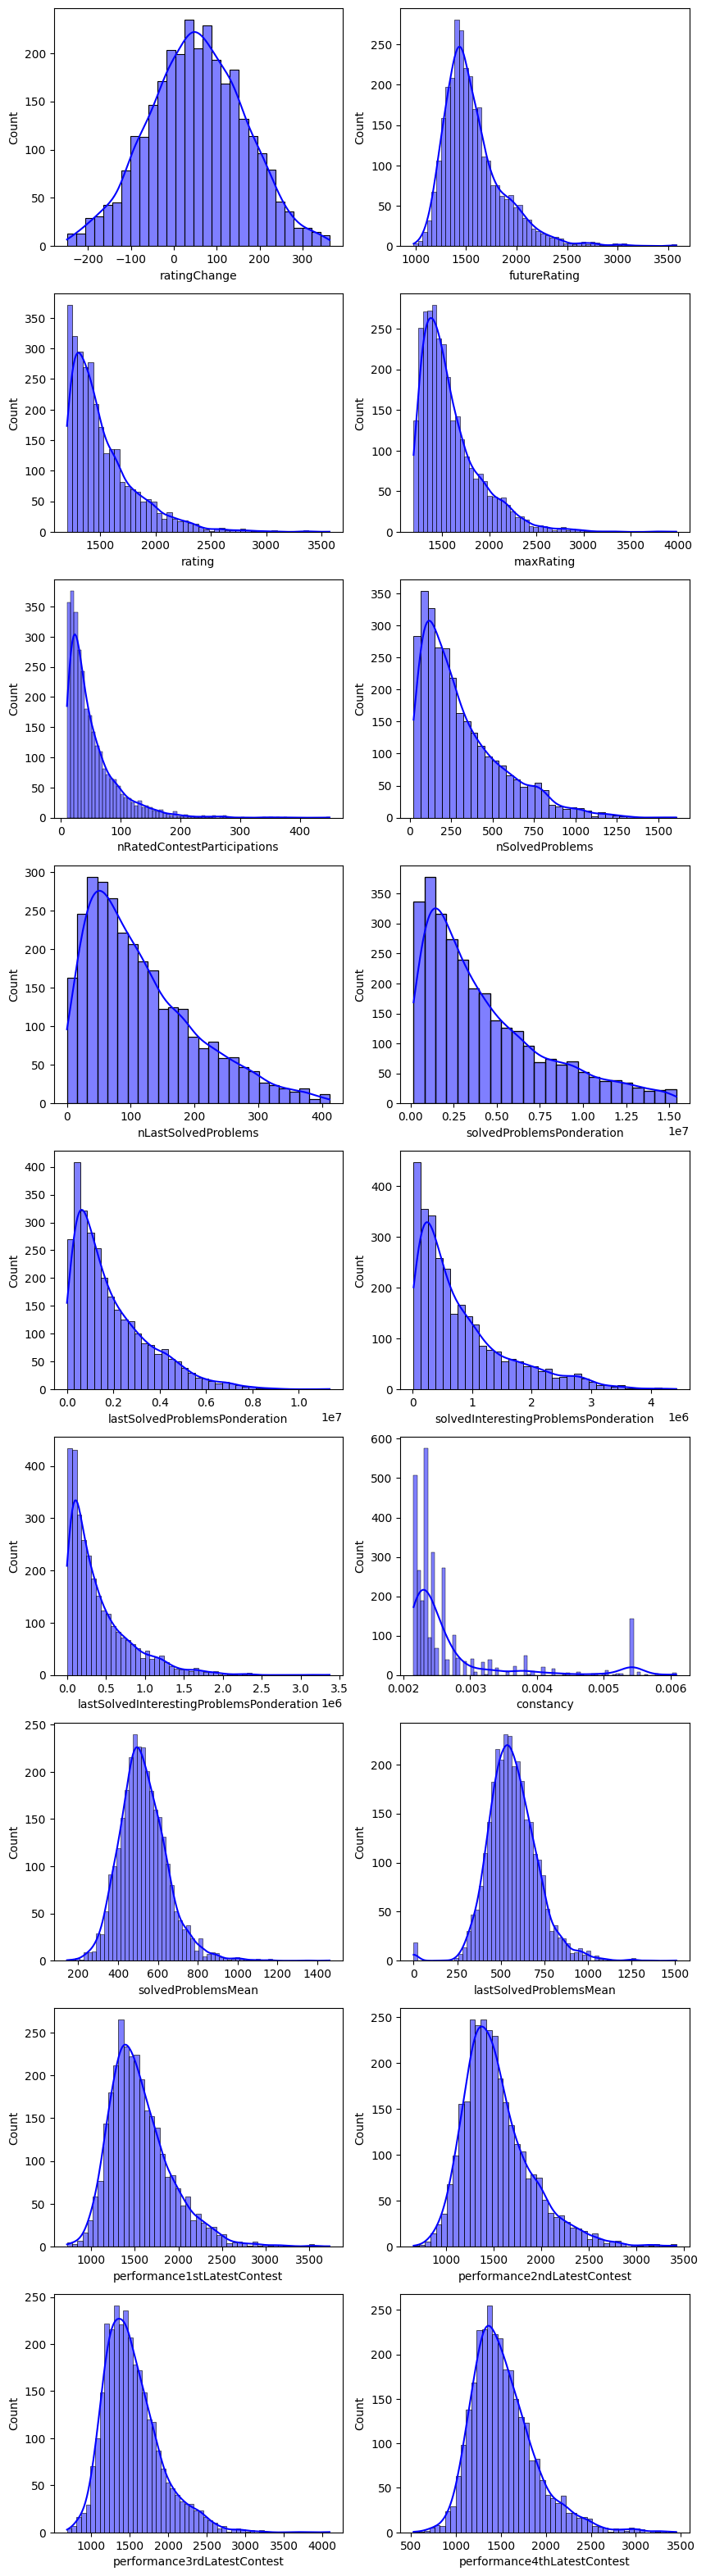

In [50]:
graph_histplots(processed_users_data_df)

<hr>

## Análisis Bivariable/Multivariable
Analizaremos las relaciones entre dos o más variables. Para esto usaremos gráficos de dispersión.

In [51]:
def correlation_graphs(df):
  all_features = ['daysSinceRegistered', 'nLastSolvedProblems', 'lastSolvedProblemsPonderation', 'solvedInterestingProblemsPonderation',
                  'lastSolvedInterestingProblemsPonderation', 'constancy', 'lastSolvedProblemsMean']

  for i in range(0,metaparameters['REQUIRED_PREV_RATED_CONTESTS']):
    all_features.append('performance' + get_ordinal(i + 1) + 'LatestContest')

  numericvars = df.copy()
  # numericvars = numericvars.drop(columns=['handle','dataExtractionTime'])
  numericvars = numericvars.drop(columns=all_features)

  g = sns.PairGrid(numericvars)
  g.map_upper(sns.histplot)
  g.map_lower(sns.kdeplot, fill=True)
  g.map_diag(sns.histplot, kde=True)

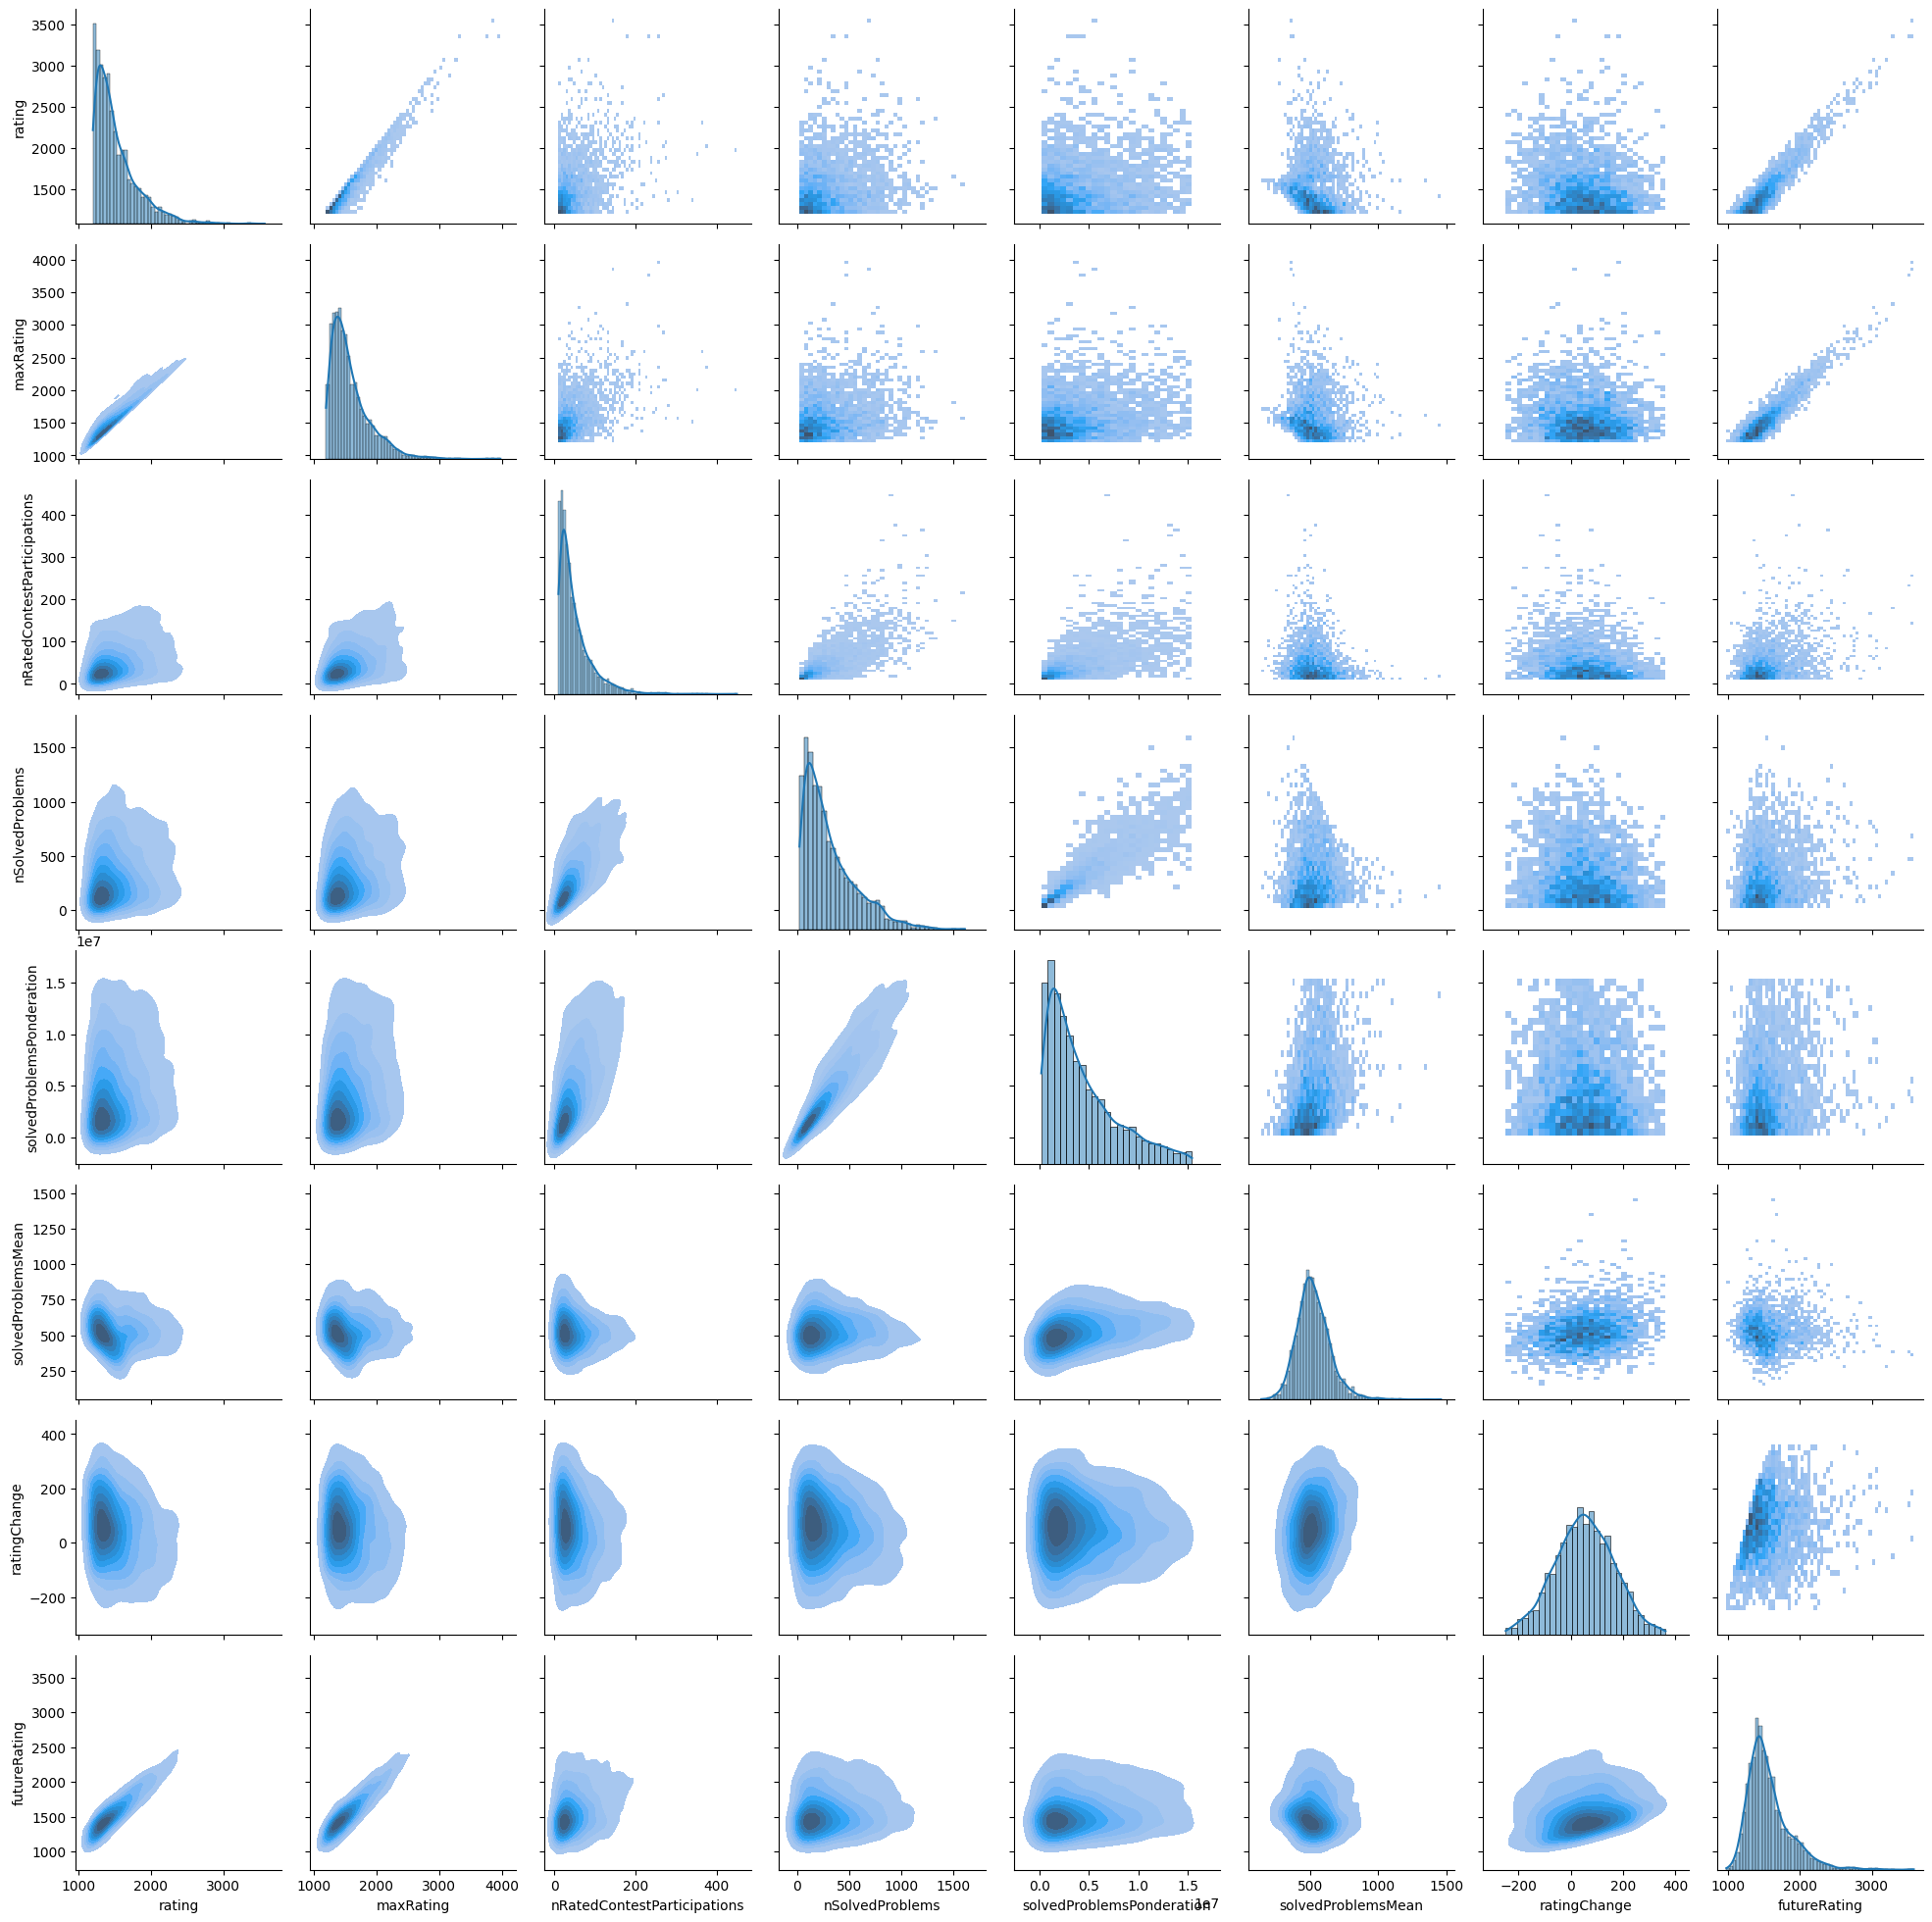

In [52]:
correlation_graphs(processed_users_data_df)

<hr>

## Correlación entre las variables

Procedemos a calcular la matriz de correlación para entender mejor las relaciones entre las variables. Esto nos ayudará a identificar qué variables independientes podrían tener una relación significativa con la variable objetivo (MEDV).


In [53]:
def graph_correlation_matrix(df):
    correlation_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(12, 7))

    sns.heatmap(
        correlation_matrix,
        vmin=correlation_matrix.values.min(),
        vmax=1,
        square=True,
        cmap="coolwarm",
        linewidths=0.03,
        annot=True,
        annot_kws={"fontsize":7}
    )

    plt.show()

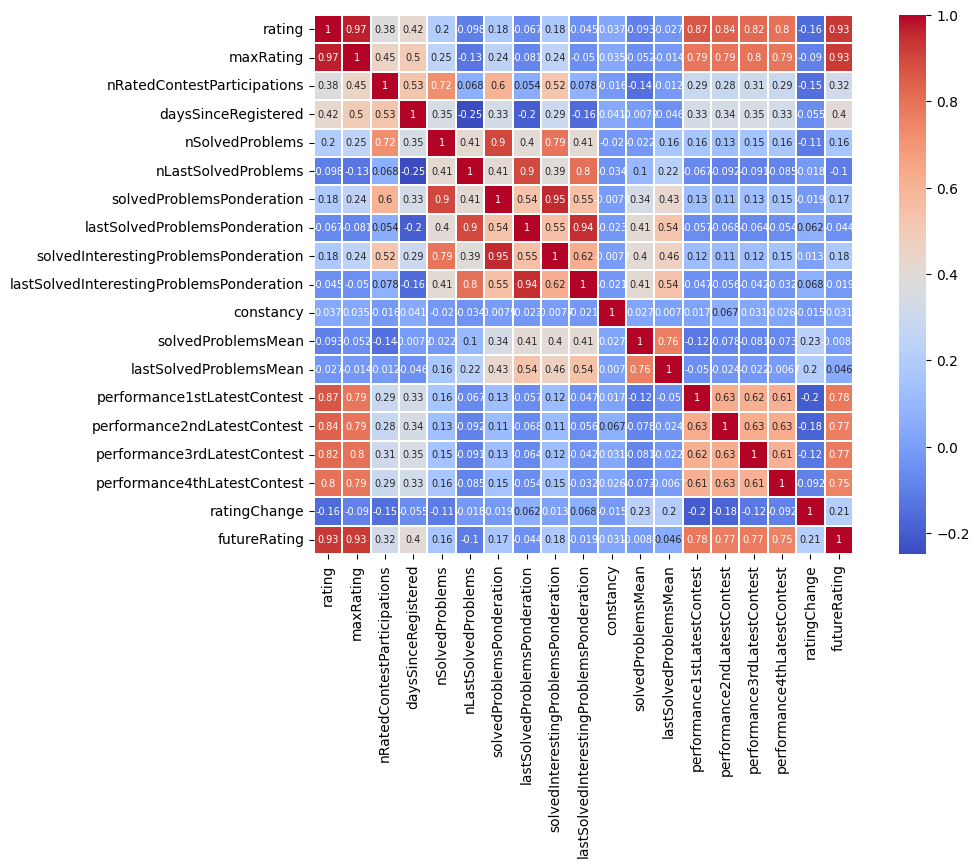

In [54]:
graph_correlation_matrix(processed_users_data_df)

<hr>

## Regresión Lineal

Utilizaremos `sklearn` y `statsmodel` para realizar la regresión lineal. Dividiremos los datos en conjuntos de entrenamiento y prueba, ajustaremos el modelo de regresión y evaluaremos su rendimiento.


In [55]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load all the features
all_features = ['rating', 'maxRating', 'nRatedContestParticipations', 'nSolvedProblems', 'nLastSolvedProblems', 'solvedProblemsPonderation',
          'lastSolvedProblemsPonderation', 'solvedInterestingProblemsPonderation', 'lastSolvedInterestingProblemsPonderation', 'constancy', 'solvedProblemsMean', 'lastSolvedProblemsMean']

for i in range(0,metaparameters['REQUIRED_PREV_RATED_CONTESTS']):
  all_features.append('performance' + get_ordinal(i + 1) + 'LatestContest')


X = processed_users_data_df[all_features];
y = processed_users_data_df['futureRating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create a new DataFrame with the scaled features and their original column names
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Reset the index of the y_train and X_train_normalized_df DataFrames
y_train_reset = y_train.reset_index(drop=True)
X_train_normalized_df_reset = X_train_normalized_df.reset_index(drop=True)
X_train_plus = sm.add_constant(X_train_normalized_df_reset)

model = sm.OLS(y_train_reset, X_train_plus).fit()
print(model.summary())

# Reset the index of the X_test_normalized_df DataFrame
X_test_normalized_df_reset = X_test_normalized_df.reset_index(drop=True)
X_test_plus = sm.add_constant(X_test_normalized_df_reset)
y_pred = model.predict(X_test_plus)

                            OLS Regression Results                            
Dep. Variable:           futureRating   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1139.
Date:                Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:36:46   Log-Likelihood:                -14395.
No. Observations:                2382   AIC:                         2.882e+04
Df Residuals:                    2365   BIC:                         2.892e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Explicación de los componentes clave del resumen del modelo de regresión lineal:
- Dep. Variable: Es la variable que estamos tratando de predecir o explicar, en este caso, 'futureRating'.
- Model: El tipo de modelo utilizado, en este caso, OLS (Ordinary Least Squares) que es un tipo común de regresión lineal.
- Method: El método utilizado para ajustar el modelo, en este caso, 'Least Squares'.
- No. Observations: El número de observaciones utilizadas en el análisis.
- Df Residuals y Df Model: Grados de libertad de los residuos y del modelo. Los grados de libertad son una medida de cuánta información "extra" tienes más allá de lo que necesitas para estimar tus parámetros de modelo.
- Covariance Type: El tipo de covarianza de los errores, en este caso, 'nonrobust'.
- R-squared: También conocido como el coeficiente de determinación, es una medida estadística que se utiliza para evaluar la bondad de ajuste de un modelo de regresión. En este caso, el valor es 0.885, lo que significa que el modelo explica el 88.5% de la variabilidad en la variable dependiente.
- Adj. R-squared: Es una versión ajustada del R-cuadrado que ha sido modificada para tener en cuenta el número de predictores en el modelo. En este caso, el valor es 0.884, lo que significa que después de ajustar por el número de predictores, el modelo explica el 88.4% de la variabilidad en la variable dependiente.
- F-statistic: Es una medida que indica si tu modelo de regresión lineal proporciona un mejor ajuste a tus datos que un modelo que contiene ninguna de tus variables independientes. En este caso, el valor es 1139, lo que indica que el modelo es estadísticamente significativo.
- Prob (F-statistic): Es la probabilidad de que obtengas un valor de la estadística F tan grande como el que tienes si la hipótesis nula es cierta, es decir, si todas tus variables independientes son inútiles. En este caso, el valor es 0.00, lo que es extremadamente pequeño, por lo que puedes rechazar la hipótesis nula y concluir que tu modelo es útil.
- Log-Likelihood: Es una medida de cuán probable es que los datos observados ocurran dado los parámetros estimados. En este caso, el valor es -14395. Los valores más altos son mejores.
- AIC (Akaike Information Criterion): Es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos. Como tal, el AIC proporciona un medio para la selección del modelo. En este caso, el valor es 2.882e+04. Los valores más bajos son mejores.
- BIC (Bayesian Information Criterion): Al igual que el AIC, el BIC es una medida de la calidad del modelo y se utiliza para la selección del modelo. También penaliza los modelos con más parámetros, pero lo hace de manera más severa que el AIC. En este caso, el valor es 2.892e+04. Los valores más bajos son mejores.
- std err: El error estándar de los coeficientes. Cuanto más pequeño es el error estándar, más precisas son nuestras estimaciones de los coeficientes.
- t: El valor t es una medida de cuántas desviaciones estándar nuestro coeficiente está lejos de 0. Queremos que este valor sea alto.
- P>|t|: El valor p es la probabilidad de que veamos los datos que tenemos si la hipótesis nula es cierta (es decir, si no hay relación). Queremos que este valor sea bajo para rechazar la hipótesis nula.
[0.025 0.975]: Estos son los límites de confianza del 95% para los coeficientes. Si este rango no incluye 0, podemos rechazar la hipótesis nula.

El R cuadrado es 0.885, lo que significa que nuestro modelo explica el 88.5% de la variabilidad en 'futureRating'. Esto es bastante alto, lo que sugiere que nuestro modelo es bastante bueno en la predicción de 'futureRating' basado en las variables incluidas.

En cuanto al análisis de los datos, de acuerdo al valor p a priori parece que, de todas las variables, solo  'rating', 'maxRating', 'nRatedContestParticipations', 'lastSolvedProblemsMean', 'performance1stLatestContest' y 'performance2ndLatestContest' son significativas en el nivel del 5% (sus valores p son menores a 0.05), lo que indica que estas variables tienen un efecto significativo en 'futureRating'. Sin embargo, el resto de las variables no parecen ser significativas en el nivel del 5%, por lo que procedimos a realizar análisis comparativos utilizando diferentes combinaciones de variables para evaluar cómo afectan al ajuste del modelo y a su capacidad predictiva. Esto implica la eliminación progresiva de variables con valor p mayor a 0.05 y la observación de cómo cambian las métricas de rendimiento del modelo, lo cual tuvo como resultado la siguiente selección de parámetros:

In [56]:
X = processed_users_data_df[['rating', 'maxRating', 'nRatedContestParticipations', 'solvedProblemsPonderation',
          'lastSolvedProblemsMean', 'performance1stLatestContest', 'performance2ndLatestContest']]
y = processed_users_data_df['futureRating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create a new DataFrame with the scaled features and their original column names
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Reset the index of the y_train and X_train_normalized_df DataFrames
y_train_reset = y_train.reset_index(drop=True)
X_train_normalized_df_reset = X_train_normalized_df.reset_index(drop=True)
X_train_plus = sm.add_constant(X_train_normalized_df_reset)

model = sm.OLS(y_train_reset, X_train_plus).fit()
print(model.summary())

# Reset the index of the X_test_normalized_df DataFrame
X_test_normalized_df_reset = X_test_normalized_df.reset_index(drop=True)
X_test_plus = sm.add_constant(X_test_normalized_df_reset)
y_pred = model.predict(X_test_plus)

                            OLS Regression Results                            
Dep. Variable:           futureRating   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     2607.
Date:                Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:36:46   Log-Likelihood:                -14398.
No. Observations:                2382   AIC:                         2.881e+04
Df Residuals:                    2374   BIC:                         2.886e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Los cambios en el modelo de regresión después del proceso de remover las variables no significativas incluyen:

- R-squared: Permaneció igual en 0.885, lo que indica que el modelo aún explica aproximadamente el 88.5% de la variabilidad en la variable "futureRating".

- Adj. R-squared: Subió de 0.884 a 0.885. Al remover variables no significativas del modelo de regresión, es posible que se haya reducido la carga de información irrelevante, permitiendo que las variables restantes contribuyan de manera más efectiva a explicar la variabilidad en la variable dependiente. Este ajuste podría haber resultado en un ligero aumento en el Adj. R-squared, indicando una mayor precisión del modelo al centrarse en las variables que realmente influyen en "futureRating".

- F-statistic: Experimentó un aumento significativo, pasando de 1139 a 2607. Esto sugiere que el modelo ajustado es aún más significativo en su conjunto.

- Prob (F-statistic): Siguió siendo prácticamente cero (0.00), lo que indica una vez más la significancia global del modelo.

- Coeficientes (coef): Los coeficientes para las variables restantes han cambiado en consecuencia.

- Intervalo de confianza (IC): Los intervalos de confianza para los coeficientes se han ajustado en consecuencia para las variables restantes.

Las variables con un valor p entre 0.05 y 0.1 podrían considerarse marginales en términos de significancia estadística. La variable "performance1stLatestContest", con un valor p de 0.056 justo por encima del umbral del 0.05, es relevante en este contexto ya que representa el rendimiento en el último concurso en el que participó el usuario, una característica relevante en el problema analizado. La decisión de mantenerla en el modelo no solo se basará en consideraciones estadísticas, sino también en el impacto potencial en la interpretación y validez del estudio, considerando factores como el tamaño de la muestra y la relevancia teórica, que pueden ser determinantes en la inclusión o exclusión de esta variable.

En resumen, aunque algunas variables fueron eliminadas del modelo, el ajuste general del modelo mejoró, y las variables restantes mantienen su significancia estadística en la predicción de la variable "futureRating". Esto sugiere que el modelo ajustado es más parsimonioso y aún efectivo para explicar la relación entre las variables incluidas.

In [57]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio: {mse}")
print(f"Raiz del Error Cuadrático Medio: {np.sqrt(mse)}")
print(f"Coeficiente de Determinación R^2: {r2}")

Error Cuadrático Medio: 10654.034663950712
Raiz del Error Cuadrático Medio: 103.21838336241618
Coeficiente de Determinación R^2: 0.8932941907575155


<hr>

## Análisis de los Supuestos

Analizaremos los residuos para verificar los supuestos del modelo. Esto nos ayudará a entender si nuestro modelo es adecuado para los datos.


In [58]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import normaltest
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import seaborn as sns
from scipy.stats import kstest
from scipy.stats import norm

residuals = model.resid

### 1. Los errores son independientes

Para comprobar este supuesto se utiliza un test de independencia sobre los residuos, el test Durbin-Watson

$H_0$: No existe correlación entre los residuos.

$H_1$: Los residuos están autocorrelacionados.

Test de Durbin-Watson: 1.92589679437928
Los residuos no están correlacionados.


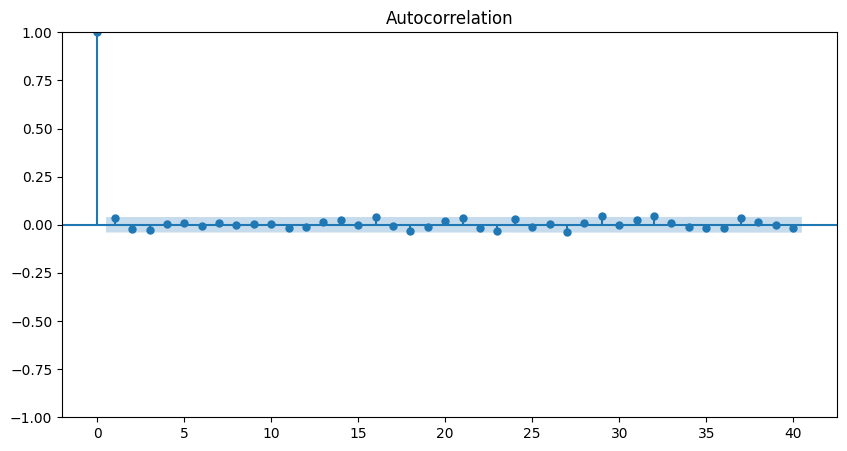

In [59]:
# Independence (Durbin-Watson Test)
dw_test = durbin_watson(residuals)

print(f'Test de Durbin-Watson: {dw_test}')

alpha = 0.5

# Interpretation
if 2 - alpha <= dw_test <= 2 + alpha:
    print("Los residuos no están correlacionados.")
elif dw_test > 2 + 0.5:
    print("Hay una autocorrelación positiva.")
else:
    print("Hay una autocorrelación negativa.")



# Calcular los residuos estandarizados
residuos_estandarizados = residuals / np.std(residuals)

# Crear el gráfico de autocorrelación
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(residuos_estandarizados, lags=40, ax=ax)
plt.show()

#### Observaciones:
La gráfica de autocorrelación muestra la correlación de los residuos con versiones desplazadas de sí mismos. En este caso, se ha calculado la autocorrelación para 40 desplazamientos diferentes. Si los residuos son independientes, esperaríamos que todas las barras en el gráfico estén cerca de cero, lo que indica que no hay correlación entre los residuos y los residuos desplazados.

En esta gráfica, se observa que todas las barras están cerca de cero y dentro del intervalo de confianza (las líneas azules punteadas), lo que indica que no hay evidencia de autocorrelación en los residuos. Esto sugiere que el supuesto de independencia de los residuos se cumple en este modelo.
<br>

### 2. El valor esperado de los errores es cero

Para comprobar este supuesto se utiliza un test para la media de una poblacion

$H_0$: $\mu _0 = 0$

$H_1$: $\mu _0 \neq 0$.

T-statistic: -0.00000, P-value: 1.00000
No hay evidencia suficiente para rechazar la hipótesis nula de que la media de los residuos es cero.


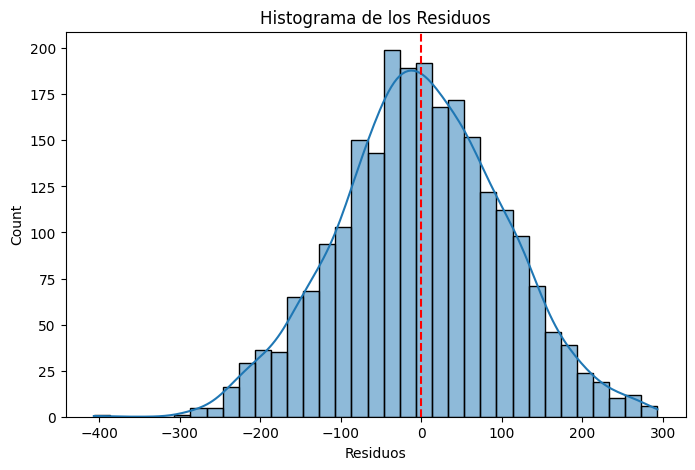

In [60]:
# Perform a one-sample t-test
t_stat, p_value = stats.ttest_1samp(residuals, 0)

print(f"T-statistic: {t_stat:.5f}, P-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Existe evidencia para rechazar la hipótesis nula de que la media de los residuos es cero.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula de que la media de los residuos es cero.")

# Crear un histograma de los residuos
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Histograma de los Residuos')
plt.xlabel('Residuos')
plt.show()

#### Observaciones
La gráfica muestra un histograma de los residuos del modelo, con una línea vertical en cero para indicar el punto de referencia. Los residuos parecen estar centrados alrededor de cero, y la forma del histograma es aproximadamente simétrica. Esto sugiere que el valor esperado de los residuos es cero, lo que es consistente con uno de los supuestos clave de la regresión lineal. Además, la forma simétrica de la distribución de los residuos sugiere que es razonable asumir que los residuos siguen una distribución normal, lo cual es otro supuesto importante en la regresión lineal.

### 3.  La Varianza del error aleatorio es constante

Para este supuesto se realiza un test de Breusch-Pagan para determinar la Homocedasticidad de los residuos.

$H_0$: La homocedasticidad está presente.

$H_1$: La homocedasticidad no está presente (es decir, existe heterocedasticidad)

Test de Breusch-Pagan. p-value: 0.0010557804852530188
Existe evidencia para rechazar la hipótesis nula de que existe presencia de homocedasticidad.
[('Lagrange multiplier statistic', 24.188068798504545), ('p-value', 0.0010557804852530188), ('f-value', 3.479162460982485), ('f p-value', 0.0010272811184520842)]


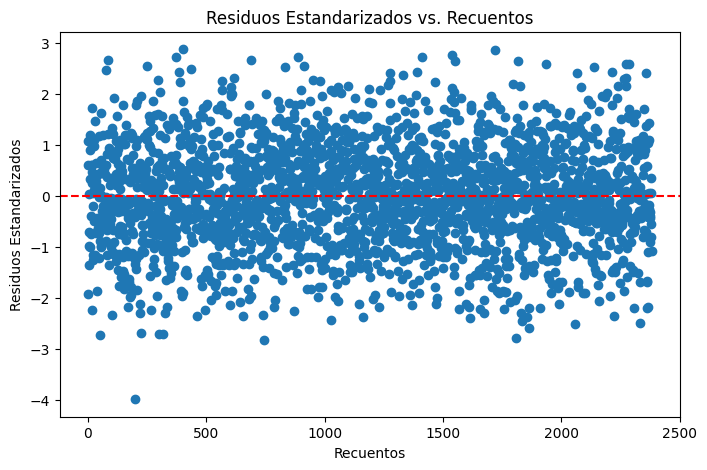

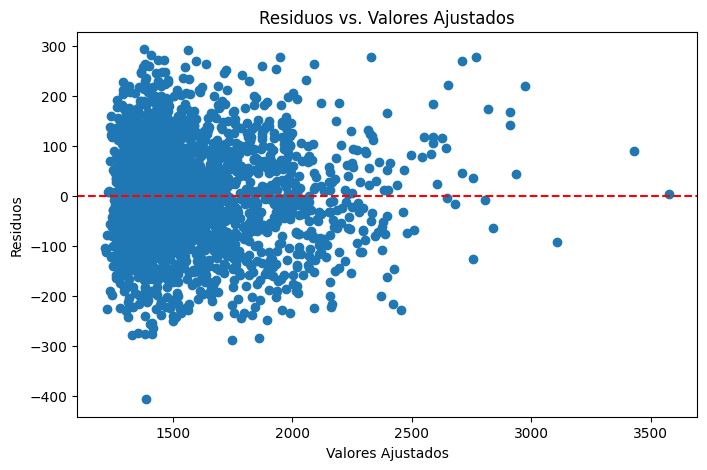

In [61]:
# Homoscedasticity (Breusch-Pagan test)
_, bp_pvalue, _, _ = het_breuschpagan(residuals, sm.add_constant(X_train_plus))

print(f'Test de Breusch-Pagan. p-value: {bp_pvalue}')

# Interpretation
if bp_pvalue < 0.05:
    print("Existe evidencia para rechazar la hipótesis nula de que existe presencia de homocedasticidad.")
else:
    print("No existe evidencia suficiente para rechazar la hipótesis nula de que existe presencia de homocedasticidad.")

# Calcular los residuos estandarizados
residuos_estandarizados = residuals / np.std(residuals)

# Realizar el test de Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Imprimir los resultados del test
print(lzip(names, test))

# Gráfico de residuos estandarizados contra recuentos
plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

# Gráfico de residuos vs. valores ajustados
plt.figure(figsize=(8, 5))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

#### Observaciones:

- La nube de puntos no sigue una tendencia lineal clara, sino que tiene una forma más bien dispersa y aleatoria. Esto puede indicar que el modelo no está explicando adecuadamente la variabilidad en los datos.
-  Hay algunos puntos que se alejan notablemente de la nube principal, sugiriendo la presencia de valores atípicos o "outliers" en los datos.
-  La línea roja central representa los valores ajustados "ideales" donde los residuos serían cero. La dispersión de los puntos alrededor de esta línea es un indicativo de la magnitud de los errores del modelo.
-  Visualmente, parece haber una mayor dispersión de los residuos a medida que aumentan los valores ajustados. Esto podría ser una señal de problemas de heterocedasticidad (varianza no constante) en los residuos.
- Como este supuesto no se cumple, no se garantiza la validez del modelo.

<br>

### 4. Los errores además son idénticamente distribuidos y siguen distribución normal con media cero y varianza constante

Para determinar la normalidad se utiliza el test de Shapiro-Wilk (n < 30) o Normality Test (n >= 30).

$H_0$: Los datos siguen una distribución Normal

$H_1$: Los datos no siguen una distribución Normal

Test de normalidad. p-value: 0.7566939169666329
No hay evidencia suficiente para rechazar la hipótesis nula de que los valores siguen una distribución normal.
D = 0.010232820184033264, p-value = 0.962139043627236


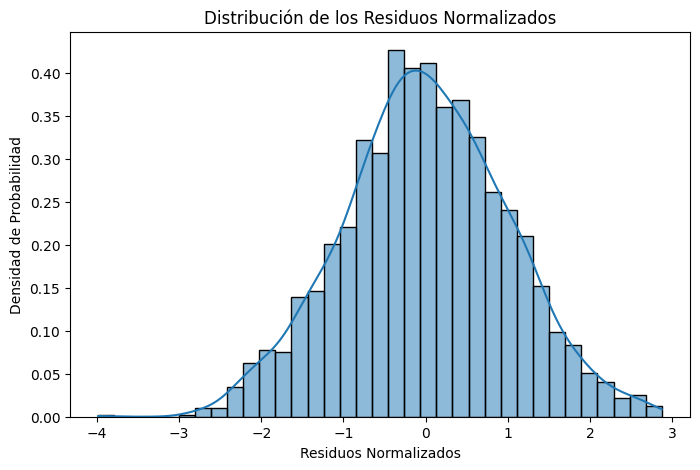

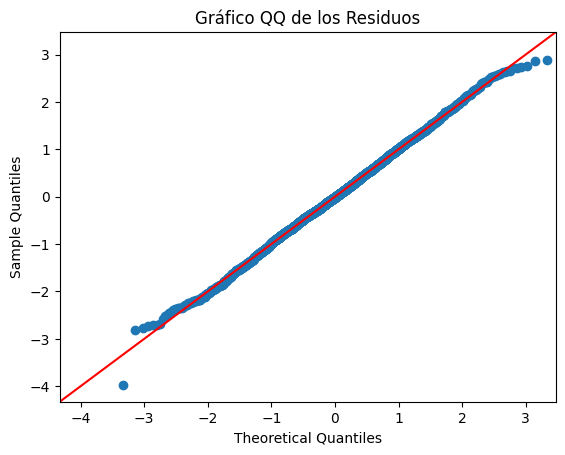

In [62]:
norm_residuals=residuals/np.std(residuals)
norm_residuals.describe()

# Normality of Errors: Shapiro-Wilk Test (use for n<30) and Normality Test (use for n>=30)
_, norm_pvalue = normaltest(norm_residuals)
print(f'Test de normalidad. p-value: {norm_pvalue}')

# Interpretation
if norm_pvalue < 0.05:
    print("Existe evidencia para rechazar la hipótesis nula de que los valores siguen una distribución normal.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula de que los valores siguen una distribución normal.")

# Realizar la prueba del Kolmogorov-Smirnov para verificar la normalidad de los residuos
D, p_value = kstest(norm_residuals, 'norm')

print(f"D = {D}, p-value = {p_value}")

# Crear el gráfico de los datos
plt.figure(figsize=(8, 5))
sns.histplot(norm_residuals, kde=True, stat='density')

plt.title('Distribución de los Residuos Normalizados')
plt.xlabel('Residuos Normalizados')
plt.ylabel('Densidad de Probabilidad')
plt.show()

# Gráfico QQ de los residuos
fig = sm.qqplot(norm_residuals, line='45')
plt.title('Gráfico QQ de los Residuos')
plt.show()

#### Observaciones:

Gráfica 1: Gráfico QQ de los Residuos
    Si bien los puntos se alinean bastante bien a lo largo de la línea recta, se observan desviaciones importantes en los extremos, especialmente en los valores más altos y más bajos.
    Esto indica que la distribución de los residuos no se ajusta perfectamente a una normal, a pesar de la apariencia inicial.

Gráfica 2: Distribución de los Residuos Normalizados
    El histograma muestra una forma ligeramente asimétrica y con colas más anchas que las de una distribución normal estándar.
    Esto sugiere que la distribución de los residuos presenta cierta curtosis y asimetría, lo cual entra en conflicto con el supuesto de normalidad.


<hr>

## Análisis de la Varianza (ANOVA)

`statsmodels` proporciona una forma detallada de realizar el análisis de la varianza (ANOVA por sus sigloides en inglés, ANalysis Of VAriance), el cual realizaremos con variables significativas como el rating change en el último contest real

In [63]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_model = ols('futureRating ~ C(nSolvedProblems) + C(rating)', data=processed_users_data_df).fit()

# Realiza la prueba ANOVA
anova_results = sm.stats.anova_lm(anova_model, typ=1)

print(anova_results)

                        df        sum_sq        mean_sq          F  \
C(nSolvedProblems)   812.0  9.031242e+07  111222.193496   8.892792   
C(rating)            893.0  1.688612e+08  189094.308420  15.119072   
Residual            1319.0  1.649674e+07   12507.004792        NaN   

                           PR(>F)  
C(nSolvedProblems)  1.136978e-259  
C(rating)            0.000000e+00  
Residual                      NaN  


Realizaremos el ANOVA para comparar 2 modelos de Machine Learning sobre el dataset además del modelo de Regresión lineal previo.

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

# Función para realizar la validación cruzada
def perform_cross_validation(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

# Crear una envoltura para statsmodels.OLS
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)


# Definir los modelos de regresión
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "OLS" : SMWrapper(sm.OLS)
}

# Realizar la validación cruzada en cada modelo y imprimir los resultados
for model_name, model in models.items():
    cv_scores = perform_cross_validation(model, X_train_plus, y_train_reset)
    print(f"{model_name} CV scores: {cv_scores}")
    print(f"{model_name} CV mean score: {cv_scores.mean()}")

Decision Tree CV scores: [155.69132365 146.31096088 147.14674976 152.13641739 148.27026482]
Decision Tree CV mean score: 149.91114330058903
Random Forest CV scores: [113.03331955 107.43780071 107.0873868  109.90443655 106.30781925]
Random Forest CV mean score: 108.75415257259795
OLS CV scores: [105.44688714 101.85984297 100.5661237  103.23365207 100.55242516]
OLS CV mean score: 102.331786210165


In [65]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ajustar los modelos y obtener los residuos
residuals = {}
for model_name, model in models.items():
    model.fit(X_train_normalized, y_train)
    predictions = model.predict(X_test_normalized)
    residuals[model_name] = y_test - predictions

# Crear un DataFrame con los residuos
residuals_df = pd.DataFrame(residuals)

# Derretir el DataFrame para que sea adecuado para ANOVA
residuals_melt = pd.melt(residuals_df.reset_index(), id_vars=['index'], value_vars=models.keys())
residuals_melt.columns = ['index', 'treatment', 'value']

# Realizar ANOVA
model = ols('value ~ C(treatment)', data=residuals_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                    sum_sq      df         F    PR(>F)
C(treatment)  4.244442e+03     2.0  0.146778  0.863496
Residual      2.580875e+07  1785.0       NaN       NaN


Esta tabla es el resultado de un análisis de varianza (ANOVA). ANOVA es una prueba estadística que se utiliza para determinar si hay diferencias significativas entre las medias de dos o más grupos. Aquí está lo que significa cada columna:

- sum_sq: Esta es la suma de cuadrados. Para "C(treatment)", es la suma de cuadrados entre grupos, que es la variación atribuible a las diferencias entre los grupos. Para "Residual", es la suma de cuadrados dentro de los grupos, que es la variación atribuible a las diferencias dentro de los grupos.

- df: Este es el grado de libertad. Para "C(treatment)", es el número de grupos menos uno. Para "Residual", es el número total de observaciones menos el número de grupos.

- F: Este es el valor F, que se utiliza para determinar la significación estadística. Se calcula dividiendo la media de cuadrados entre grupos por la media de cuadrados dentro de los grupos.

- PR(>F): Este es el valor p, que es la probabilidad de obtener un valor F al menos tan extremo como el que se obtuvo, asumiendo que la hipótesis nula es cierta. Si el valor p es menor que el nivel de significancia (generalmente 0.05), entonces se rechaza la hipótesis nula.

En este caso, el valor p para "C(treatment)" es 0.870361, que es mayor que 0.05. Por lo tanto, no hay evidencia suficiente para rechazar la hipótesis nula de que las medias de los grupos son iguales. Esto significa que, basándonos en nuestros datos, no podemos concluir que haya una diferencia significativa en el rendimiento de los dos modelos de regresión que hemos utilizado (DecisionTreeRegressor y RandomForestRegressor).

<hr>
Los tres modelos utilizados aquí son técnicas de regresión lineal, pero cada uno tiene un enfoque ligeramente diferente para manejar la complejidad del modelo y evitar el sobreajuste.

- `Decision Tree` (Árbol de Decisión): Este modelo crea una estructura de árbol donde cada nodo representa una característica (o atributo), cada enlace (o rama) representa una decisión (regla) y cada hoja representa un resultado (categórico o continuo). La principal ventaja de este modelo es su facilidad de interpretación y comprensión. Sin embargo, los árboles de decisión pueden crear modelos complejos que no generalizan bien los datos, lo que puede llevar al sobreajuste.

- `Random Forest` (Bosque Aleatorio): Este modelo es un método de conjunto que combina múltiples árboles de decisión para obtener mejores resultados. Cada árbol se construye de manera un poco diferente, lo que significa que cada uno puede capturar diferentes aspectos de los datos. Luego, las predicciones de todos los árboles se combinan para producir la predicción final. Los bosques aleatorios son una forma de reducir el sobreajuste de los árboles de decisión y pueden manejar bien una gran cantidad de características y datos de entrenamiento.

- `OLS` (Mínimos Cuadrados Ordinarios): Este es el modelo de regresión lineal más simple y no utiliza ninguna regularización. Esto significa que puede ser más susceptible al sobreajuste si hay muchas características y no hay suficientes datos de entrenamiento. Sin embargo, si las características son todas relevantes y no hay demasiado ruido en los datos, OLS puede funcionar muy bien.

El hecho de que los tres modelos den resultados similares sugiere que, para este conjunto de datos específico, la regularización no está teniendo un gran impacto. Esto podría ser porque todas las características son relevantes para la predicción, o podría ser que los datos sean lo suficientemente limpios y abundantes que el sobreajuste no sea un problema importante. Esto sugiere que la elección del modelo puede no ser el factor más importante para mejorar el rendimiento en este caso.

<hr>

## Análisis de Componentes Principales (PCA)

El Análisis de Componentes Principales (PCA) es una técnica que utilizamos para reducir la cantidad de variables en nuestros datos, especialmente cuando estas variables pueden estar correlacionadas entre sí. La idea es transformar estas variables en un nuevo conjunto de variables, llamadas componentes principales, que no están correlacionadas entre sí.

En nuestro código, utilizaremos PCA para simplificar nuestros datos. Primero, seleccionamos solo las columnas numéricas de nuestros datos y llenamos cualquier valor faltante con la media de esa columna. Luego, ajustamos y transformamos nuestros datos con PCA.

Como resultado de este ajuste y transformación, obtenemos un conjunto de componentes principales. Cada componente principal es una combinación de nuestras variables originales y cada uno explica una cierta cantidad de la variación en nuestros datos. Visualizamos la cantidad de variación explicada por cada componente principal en un gráfico de barras.

Después, elegimos un número específico de componentes (en este caso, 3) y realizamos PCA nuevamente con este número de componentes. Los resultados se almacenan en un DataFrame y se visualizan en un mapa de calor.

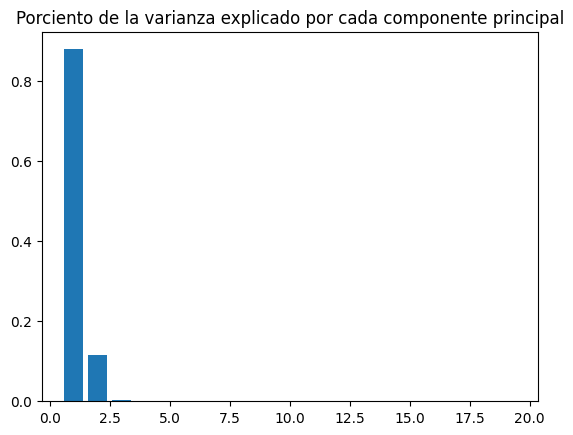

,PC1,PC2
rating,1.258943e-05,-4.710545e-05
maxRating,1.836000e-05,-6.510571e-05
nRatedContestParticipations,6.493221e-06,-1.230364e-05
daysSinceRegistered,4.806117e-05,-2.295279e-04
nSolvedProblems,5.806573e-05,-3.529130e-05
nLastSolvedProblems,1.143853e-05,4.751242e-05
solvedProblemsPonderation,9.385903e-01,-2.822349e-01
lastSolvedProblemsPonderation,2.755808e-01,9.355523e-01
solvedInterestingProblemsPonderation,1.959243e-01,-3.713578e-02
lastSolvedInterestingProblemsPonderation,6.868104e-02,2.090605e-01


In [82]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


processed_users_data_df_numeric = processed_users_data_df.select_dtypes(include=[np.number])


# Rellenar los valores NaN con la media de la columna
processed_users_data_df_filled = processed_users_data_df_numeric.copy()
for col in processed_users_data_df_numeric.columns:
    if pd.api.types.is_numeric_dtype(processed_users_data_df_numeric[col]):
        processed_users_data_df_filled[col] = processed_users_data_df_numeric[col].fillna(processed_users_data_df_numeric[col].mean())

# Crear el objeto PCA
pca = PCA()

# Ajustar y transformar los datos
pca.fit_transform(processed_users_data_df_filled)

variance_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(variance_ratio.shape[0]) + 1, variance_ratio)
plt.title("Porciento de la varianza explicado por cada componente principal")
plt.show()

component_count = 2
pca = PCA(component_count)
principalComponents = pca.fit_transform(processed_users_data_df_filled)
principal_Df = pd.DataFrame(data = principalComponents)
analysis = pd.DataFrame(pca.components_, columns=processed_users_data_df_filled.columns, index=[f'PC{i}' for i in range(1,component_count+1)]).T
analysis


<Axes: >

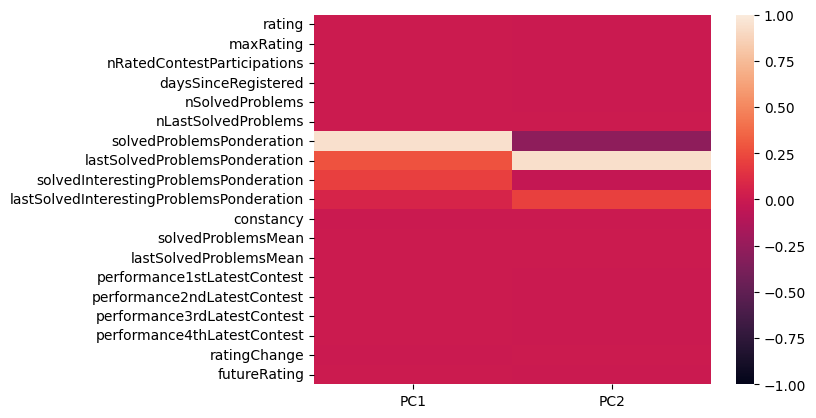

In [83]:
sns.heatmap(analysis, vmin=-1, vmax=1)

#### Conclusiones:

- En la primera imagen, vemos que el primer componente principal (PC1) explica aproximadamente el 85% de la varianza de los datos. Esto indica que este primer componente captura la mayor parte de la información contenida en los datos originales.
- En la segunda imagen, observamos que las variables relacionadas con los problemas resueltos y su ponderación parecen tener una importancia muy variable entre las 2 componentes principales. La variabilidad en la importancia de las variables relacionadas con los problemas resueltos entre las tres componentes principales en un PCA sugiere que diferentes aspectos de esos problemas están siendo capturados por cada componente. Esto puede reflejar correlaciones variables entre las variables en cada componente, así como la contribución única de ciertos tipos de problemas a la estructura de variabilidad en los datos, proporcionando una comprensión más profunda de su naturaleza y relación.
- En general, el análisis de PCA nos permite reducir la dimensionalidad de los datos sin perder una cantidad significativa de información. Esto puede ser útil para simplificar el análisis y comprensión de estos datos.
- Los valores de los componentes principales son muy pequeños, lo que indica que cada característica contribuye poco a la varianza total de los datos. Esto puede ser un indicativo de que las características son bastante independientes entre sí.


## PCA con menos datos:

In [84]:
# Seleccionar una muestra aleatoria de 200 filas
sample_df = processed_users_data_df_filled.sample(n=200)

component_count = 2
pca = PCA(component_count)
principalComponents = pca.fit_transform(sample_df)
principal_Df = pd.DataFrame(data = principalComponents)
analysis = pd.DataFrame(pca.components_, columns=sample_df.columns, index=[f'PC{i}' for i in range(1,component_count+1)]).T
analysis

,PC1,PC2
rating,9.722296e-06,-4.059172e-05
maxRating,1.548927e-05,-5.451216e-05
nRatedContestParticipations,6.535344e-06,-1.082704e-05
daysSinceRegistered,3.957183e-05,-2.017680e-04
nSolvedProblems,5.573662e-05,-4.129209e-05
nLastSolvedProblems,8.754246e-06,4.485686e-05
solvedProblemsPonderation,9.481225e-01,-2.431162e-01
lastSolvedProblemsPonderation,2.418463e-01,9.494729e-01
solvedInterestingProblemsPonderation,1.991147e-01,-4.793137e-02
lastSolvedInterestingProblemsPonderation,5.410571e-02,1.926092e-01


<Axes: >

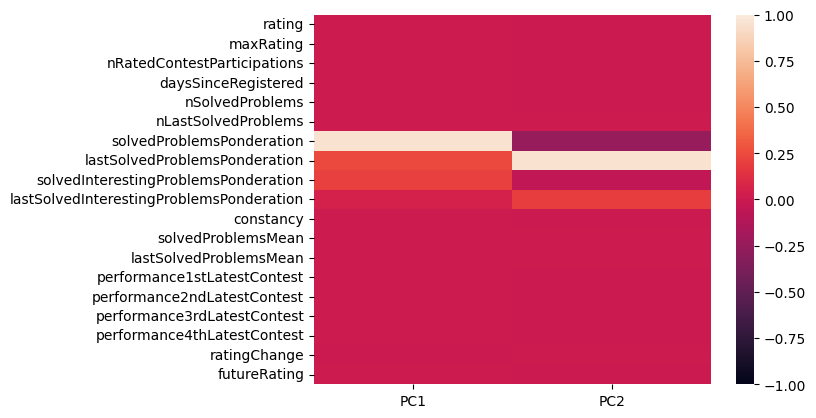

In [85]:
sns.heatmap(analysis, vmin=-1, vmax=1)

Conclusiones:

- Al realizar el análisis de componentes principales (PCA) con una muestra más pequeña de datos (200 filas seleccionadas aleatoriamente), los resultados no cambiaron significativamente. Esto sugiere que el PCA no se ve afectado por factores numéricos debido a la cantidad de datos.
- A pesar de la reducción de la muestra de datos, los resultados del PCA siguen siendo consistentes, lo que sugiere que el PCA es robusto a la cantidad de datos utilizados.

